We explain in this tutorial the basic usage of a new Mulitscale-CLEAN algorithm (DoB-CLEAN). The algorithm uses for the first time mulitiscalar and multidirectional dictionaries fitted to the uv-coverage to represent an image. The image is represented by DoG-wavelets, while the Fourier domain is analyzed with DoB-wavelets. The dirty image is represented by suitable DoB-wavelets, the cleaning step is done by a transition between the two dictionaries.

Note that for this tutorial a parallel computing system with a large memory is needed.

Let us first load all the neccessary modules.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

from imagingbase.ehtim_wrapper import EhtimWrapper
from imagingbase.solvers.clean_handler import CLEAN

import pathlib 
current_path = str(pathlib.Path().absolute())

import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.4 



and define some fixed imaging parameters.

In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'fast'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 1.0                 # Total compact flux density (Jy)
npix      = 1024                 # Number of pixels across the reconstructed image
fov       = 10**6*eh.RADPERUAS    # Field of view of the reconstructed image

We load the observational data and the true solution.

Loading uvfits:  /homes/hmueller/mr_beam/synthesis_regpy/examples/../synthetic_data/gaussian_ellipse_obs.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  /homes/hmueller/mr_beam/synthesis_regpy/examples/../synthetic_data/gaussian_ellipse.fits


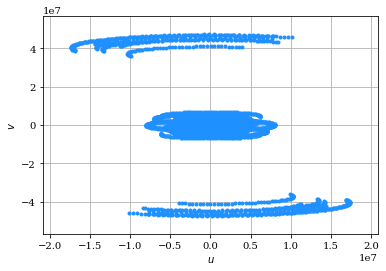

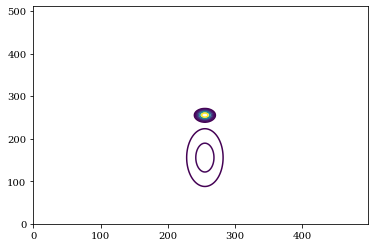

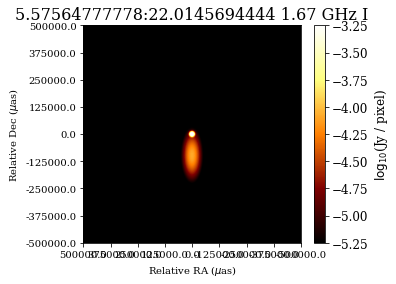

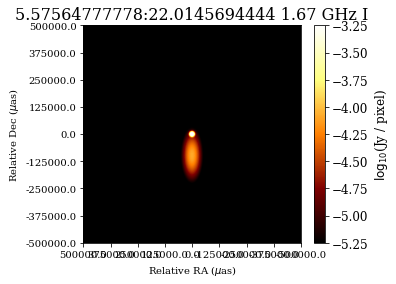

In [3]:
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/gaussian_ellipse_obs.fits')
img = eh.image.load_fits(current_path+r'/../synthetic_data/gaussian_ellipse.fits')

obs_sc.plotall('u', 'v', conj=True)

peak = np.max(img.imarr())
levels = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
plt.contour(img.imarr()[256:768,256:756][::-1], levels=peak*levels)
plt.show()

img.display(scale='log', cbar_lims=[-5.25, -3.25])

We define the clean beam width for plotting. If not defined, the clean beam width will be computed by fitting the central peak of the dirty beam later.

In [4]:
psf_fwhm1 = 0.01779*eh.RADPERAS
psf_fwhm2 = 0.004309*eh.RADPERAS
angle = -np.pi/180*8.73

psfprior = eh.image.make_square(obs_sc, npix//4, fov)
psfprior = psfprior.add_gauss(1, (psf_fwhm1, psf_fwhm2, angle, 0, 0))

We compute the wrapper object to ehtim again as before. The DoB-CLEAN code is fully parallized (several scales could be handled in parallel), so we also specify the number of cores to use.

In [5]:
psfprior = psfprior.regrid_image(fov, npix+1)

wrapper = EhtimWrapper(obs_sc.copy(), psfprior, psfprior, zbl, d='vis', ttype=ttype, clipfloor=-100, num_cores=16)
widths = wrapper.find_widths(5*10**6, fov=0.2)

Generating I image...


The initial calculation of the dirty beam and the dirty map with many pixels may take some time. To reduce the waiting time, let us load some dirty beam and dirty map instances that we pre-computed for this tutorial.

In [6]:
dmap = np.load(current_path+r'/../synthetic_data/dmap.npy')
dbeam = np.load(current_path+r'/../synthetic_data/dbeam.npy')

Now we define the (MS-) CLEAN instance to run. This instance does the whole computation, but it also provides handling of interactive plotting and data manipulation similar to the working procedures known from Difmap.

The CLEAN instance needs to know the following parameters:
-> wrapper: The wrapper object to ehtim, also contains the observation file
-> method: Which version of CLEAN to use, e.g. 'Hogbom' for standard CLEAN and 'Hybrid' for DoB-CLEAN
-> widths: The widths of the DoB-wavelets to fit to the uv-coverage

Furthermore, optionally, we define the power of the correction with instrumental noise (power) and the power of the correction for gridding (uweight=0: natural, uweight=1: uniform). We specify to take the plotting beam from the prior, and specify how many fwhms wide we compute the wavelets (nsigma should be always >= 5). We specify to use a multi-directional transform by md=True and how many different angles we use by ellipticities. The padding factor for the numerical computation of the Fourier transforms can be given explicitly. To reduce computing time, we use the precomputed dirty map and dirty beam directly without recomputing them. Moreover, we specify that by udbeam_threshold that scales with a filling factor in the Fourier domain smaller than some threshold (default 0.1) will be ignored during modelling of the solution. 

There are more options to specify, please look up the documentation for these.

In [7]:
solver = CLEAN(wrapper, 'Hybrid', widths, power=1, uweight=0, psf_from_prior=True, nsigma=10, md=True, ellipticities=4, padding_factor=1, sdmap=dmap, sdbeam=dbeam, udbeam_threshold=True)

2022-08-05 14:07:27,319 INFO CLEAN                :: Initialize solver ...
2022-08-05 14:07:27,321 INFO CLEAN                :: Initialize dirty beam and dirty map ...
2022-08-05 14:08:09,842 INFO CLEAN                :: Initialize merger ...
2022-08-05 14:08:42,133 INFO CLEAN                :: Build merger ...
2022-08-05 14:09:07,473 INFO CLEAN                :: Build solver ...
2022-08-05 14:09:07,492 INFO HybridCLEAN          :: Initialize MS-decompositions ...
2022-08-05 14:09:46,384 INFO HybridCLEAN          :: Decompose Beam ...
2022-08-05 14:09:54,832 INFO HybridCLEAN          :: Compute Cross-terms ...
2022-08-05 14:15:14,198 INFO HybridCLEAN          :: Decompose psf ...
2022-08-05 14:15:23,423 INFO HybridCLEAN          :: Decompose map ...
2022-08-05 14:15:59,888 INFO HybridCLEAN          :: Compute weights ...
2022-08-05 14:18:03,832 INFO CLEAN                :: Finalize initialization ...


Let us define some variable parameters of the CLEANing procedure: the plotting bounds, the multiscalar weights, the gain parameter, the initial window (limits), and the plotting contours.

In [8]:
bounds = np.array([npix//4, 3*npix//4, npix//4, 3*npix//4], dtype=int)

dictionary = {
    "weights" : np.ones(solver.solver.length, dtype=float),
    "gain" : 0.2,
    "limits" : bounds
}

solver.set_bounds_from_script(bounds)
solver.precompute_from_dictionary(dictionary)

solver.update_levels(np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64]))

2022-08-05 14:18:34,009 INFO CLEAN                :: Specify Plotting Bounds
2022-08-05 14:18:34,012 INFO CLEAN                :: [256 768 256 768]


We inspect the data and present some data inspection tools implemented in MrBeam. When solver.display() is run in interactive mode, one can set CLEAN windows by drawing a rectangle on the screen with the mouse.

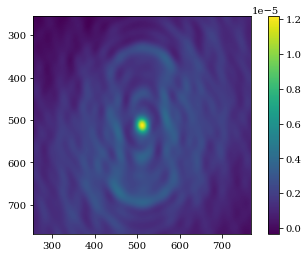

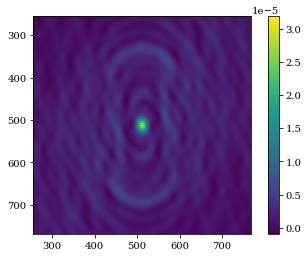

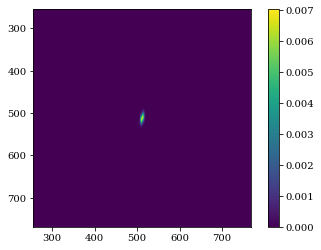

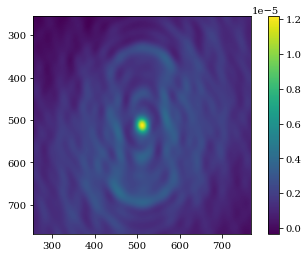

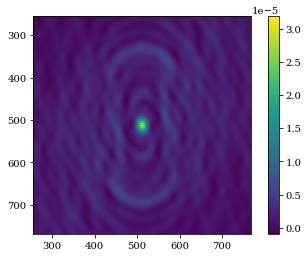

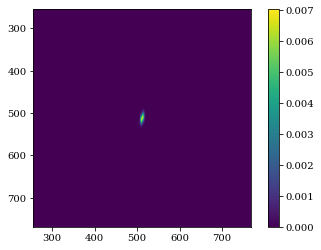

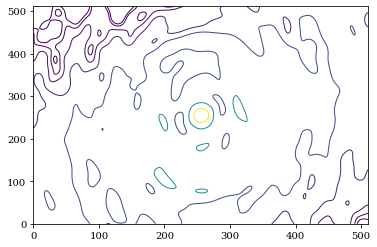

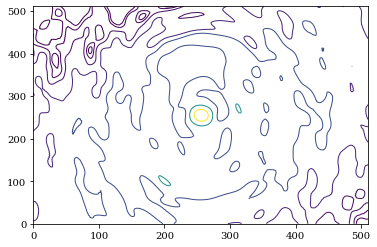

In [9]:
solver.plot("dmap") #plot residual
solver.plot("dbeam") #plot dbeam
solver.plot("psf") #plot restoring beam
solver.display() #display current iterate
solver.display(psf=False) #display super-resolving (not convolved with beam) structures

Let us run DoB-CLEAN for 100 iterations and inspect the result.

2022-08-05 14:18:42,844 INFO CLEAN                :: Start running CLEAN with 100 iterations
2022-08-05 14:18:43,974 INFO CountIterations      :: iteration = 1 / 100
2022-08-05 14:18:44,841 INFO CountIterations      :: iteration = 2 / 100
2022-08-05 14:18:45,627 INFO CountIterations      :: iteration = 3 / 100
2022-08-05 14:18:46,379 INFO CountIterations      :: iteration = 4 / 100
2022-08-05 14:18:47,244 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:18:48,003 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:18:48,757 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:18:49,510 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:18:50,259 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:18:51,012 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:18:51,775 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:18:52,536 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:18:53,305 INFO

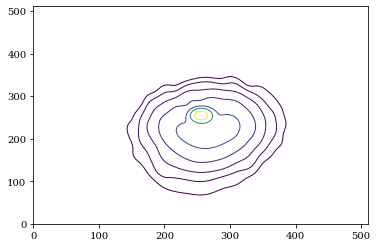

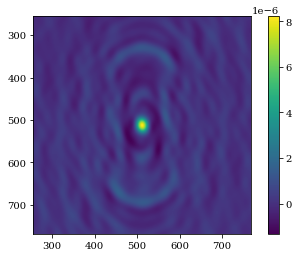

Producing clean visibilities from image with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


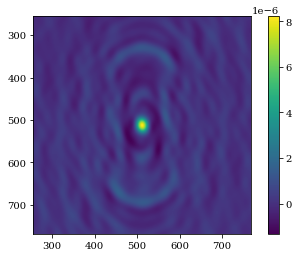

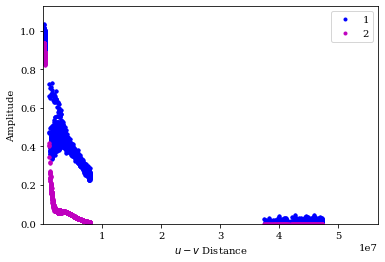

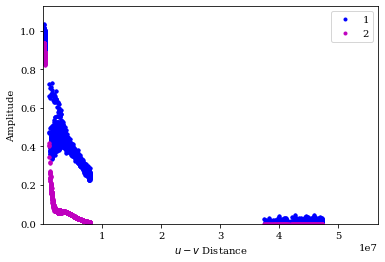

In [10]:
solver.run(100)

solver.display(psf=False) #contour plot
solver.plot("dmap") #plot residual
solver.plot("fit") #plot current fit to amplitudes

The algorithm fits the large scales first to fit the short baselines. The long baselines are then fitted in later iterations. We can also plot the fit to other quantities with the same syntax.

/aux/vlb051a/anaconda3/envs/mrbeam/lib/python3.10/site-packages/ehtim/obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


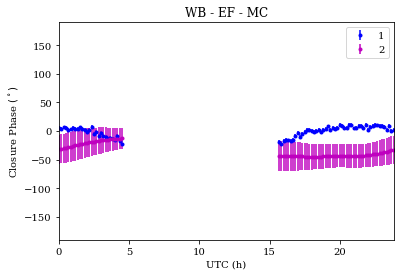

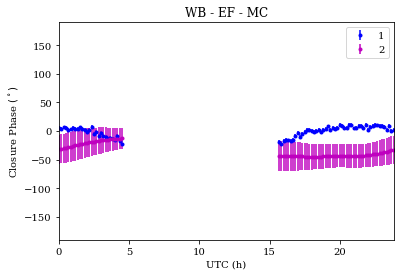

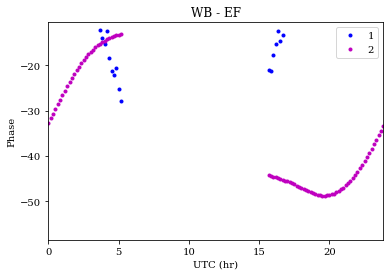

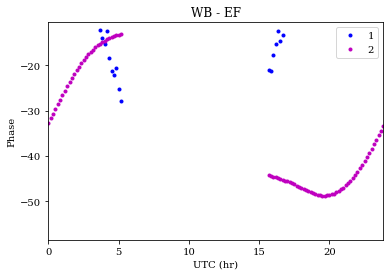

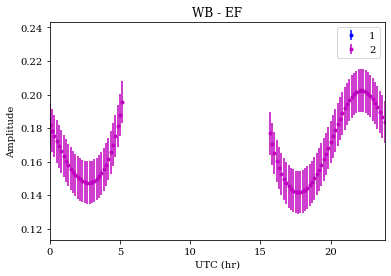

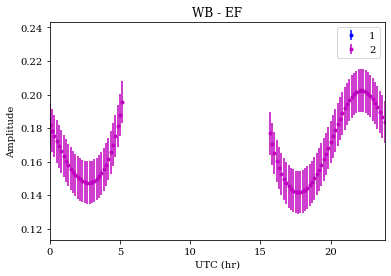

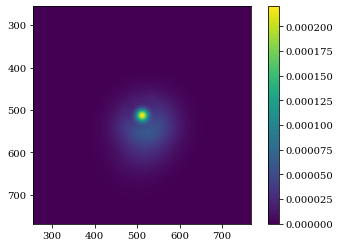

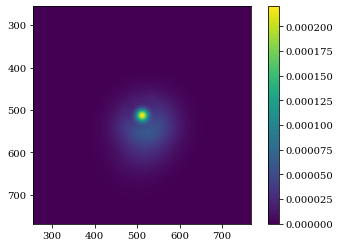

In [11]:
solver.plot("cphase", fields=['WB', 'EF', 'MC']) #closure phase
solver.plot("phase", fields=['WB', 'EF']) #phase
solver.plot("amp", fields=['WB', 'EF']) #amplitude

solver.plot("cmap") #restored map

The reconstruction is very worse, we stopped the iterations too early. We will continue the iterations later, but present some features of MrBeam first. The current model can be deleted on various ways.

In [12]:
solver.clrmod("last") #removes all components from the last run() command, fast
solver.clrmod("all") #removes all components, slow
solver.set_reco(0*solver.reco) #set a zero initial solution

2022-08-05 14:21:54,487 INFO CLEAN                :: clear mod
2022-08-05 14:21:54,490 INFO CLEAN                :: last
2022-08-05 14:21:54,491 INFO CLEAN                :: with scales
2022-08-05 14:21:54,492 INFO CLEAN                :: all
2022-08-05 14:21:54,933 INFO CLEAN                :: clear mod
2022-08-05 14:21:54,934 INFO CLEAN                :: all
2022-08-05 14:21:54,935 INFO CLEAN                :: with scales
2022-08-05 14:21:54,935 INFO CLEAN                :: all
2022-08-05 14:22:23,126 INFO CLEAN                :: Set restored map


Clear window all


2022-08-05 14:23:07,699 INFO CLEAN                :: Update window


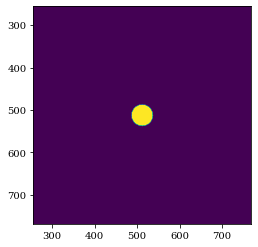

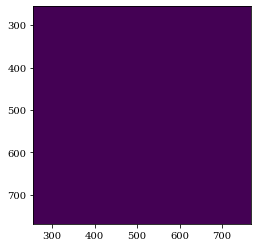

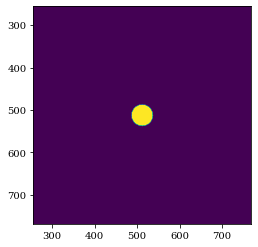

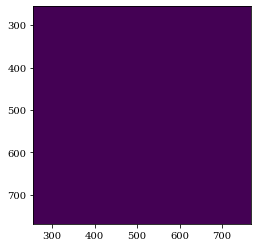

In [13]:
#Delete current window
solver.clrwind("all")

#Define circular window
from regpy.discrs import UniformGrid
grid = UniformGrid((0, npix, npix+1), (0, npix, npix+1))
window = np.zeros(solver.dmap.shape, dtype=bool)
center = [npix//2, npix//2]
radius = 25 
for i in range(npix+1):
    for j in range(npix+1):
        diff = np.linalg.norm(grid.coords[:, i, j]-center)
        window[i, j] = ( diff <= radius )
        
solver.update_window(window.flatten())

#plot window
solver.plot("window")

#Set back window to default full field
solver.precompute_from_dictionary(dictionary)
solver.plot("window")

Let us now run the DoB-CLEANing for more iterations. We iteratively recompute the multiscalar decomposition of the residual to avoid the accumulation of numerical errors.

In [14]:
for i in range(10):
    solver.run(100, recompute_map_list=True)
    
for i in range(4):
    solver.run(500, recompute_map_list=True)

2022-08-05 14:23:15,048 INFO CLEAN                :: Start running CLEAN with 100 iterations
2022-08-05 14:23:16,098 INFO CountIterations      :: iteration = 1 / 100
2022-08-05 14:23:16,574 INFO CountIterations      :: iteration = 2 / 100
2022-08-05 14:23:17,037 INFO CountIterations      :: iteration = 3 / 100
2022-08-05 14:23:17,523 INFO CountIterations      :: iteration = 4 / 100
2022-08-05 14:23:18,012 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:23:18,471 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:23:18,939 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:23:19,391 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:23:19,854 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:23:20,313 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:23:20,767 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:23:21,228 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:23:21,699 INFO

2022-08-05 14:24:37,550 INFO CountIterations      :: iteration = 1 / 100
2022-08-05 14:24:38,370 INFO CountIterations      :: iteration = 2 / 100
2022-08-05 14:24:39,220 INFO CountIterations      :: iteration = 3 / 100
2022-08-05 14:24:40,067 INFO CountIterations      :: iteration = 4 / 100
2022-08-05 14:24:40,827 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:24:41,581 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:24:42,345 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:24:43,136 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:24:43,890 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:24:44,647 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:24:45,409 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:24:46,180 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:24:46,948 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:24:47,701 INFO CountIterations   

2022-08-05 14:26:30,908 INFO CountIterations      :: iteration = 2 / 100
2022-08-05 14:26:31,742 INFO CountIterations      :: iteration = 3 / 100
2022-08-05 14:26:32,510 INFO CountIterations      :: iteration = 4 / 100
2022-08-05 14:26:33,282 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:26:34,063 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:26:34,926 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:26:35,693 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:26:36,460 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:26:37,314 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:26:38,081 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:26:38,855 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:26:39,621 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:26:40,400 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:26:41,166 INFO CountIterations  

2022-08-05 14:28:23,805 INFO CountIterations      :: iteration = 3 / 100
2022-08-05 14:28:24,344 INFO CountIterations      :: iteration = 4 / 100
2022-08-05 14:28:24,797 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:28:25,265 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:28:25,806 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:28:26,261 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:28:26,725 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:28:27,208 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:28:27,664 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:28:28,177 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:28:28,630 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:28:29,086 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:28:29,543 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:28:30,006 INFO CountIterations 

2022-08-05 14:29:46,832 INFO CountIterations      :: iteration = 4 / 100
2022-08-05 14:29:47,595 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:29:48,358 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:29:49,122 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:29:49,980 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:29:50,744 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:29:51,498 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:29:52,352 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:29:53,106 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:29:53,860 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:29:54,622 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:29:55,385 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:29:56,228 INFO CountIterations      :: iteration = 16 / 100
2022-08-05 14:29:56,989 INFO CountIterations

2022-08-05 14:31:39,542 INFO CountIterations      :: iteration = 5 / 100
2022-08-05 14:31:40,298 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:31:41,056 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:31:41,820 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:31:42,574 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:31:43,350 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:31:44,111 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:31:44,869 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:31:45,622 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:31:46,459 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:31:47,224 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:31:47,988 INFO CountIterations      :: iteration = 16 / 100
2022-08-05 14:31:48,755 INFO CountIterations      :: iteration = 17 / 100
2022-08-05 14:31:49,517 INFO CountIteration

2022-08-05 14:33:31,886 INFO CountIterations      :: iteration = 6 / 100
2022-08-05 14:33:32,337 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:33:32,803 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:33:33,269 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:33:33,721 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:33:34,187 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:33:34,654 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:33:35,106 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:33:35,599 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:33:36,086 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:33:36,555 INFO CountIterations      :: iteration = 16 / 100
2022-08-05 14:33:37,020 INFO CountIterations      :: iteration = 17 / 100
2022-08-05 14:33:37,477 INFO CountIterations      :: iteration = 18 / 100
2022-08-05 14:33:38,010 INFO CountIteratio

2022-08-05 14:34:55,648 INFO CountIterations      :: iteration = 7 / 100
2022-08-05 14:34:56,407 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:34:57,290 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:34:58,083 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:34:58,859 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:34:59,705 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:35:00,468 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:35:01,237 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:35:02,007 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:35:02,768 INFO CountIterations      :: iteration = 16 / 100
2022-08-05 14:35:03,528 INFO CountIterations      :: iteration = 17 / 100
2022-08-05 14:35:04,311 INFO CountIterations      :: iteration = 18 / 100
2022-08-05 14:35:05,085 INFO CountIterations      :: iteration = 19 / 100
2022-08-05 14:35:05,864 INFO CountIterati

2022-08-05 14:36:48,264 INFO CountIterations      :: iteration = 8 / 100
2022-08-05 14:36:49,016 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:36:49,853 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:36:50,702 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:36:51,465 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:36:52,231 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:36:52,996 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:36:53,759 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:36:54,521 INFO CountIterations      :: iteration = 16 / 100
2022-08-05 14:36:55,286 INFO CountIterations      :: iteration = 17 / 100
2022-08-05 14:36:56,147 INFO CountIterations      :: iteration = 18 / 100
2022-08-05 14:36:56,917 INFO CountIterations      :: iteration = 19 / 100
2022-08-05 14:36:57,679 INFO CountIterations      :: iteration = 20 / 100
2022-08-05 14:36:58,440 INFO CountIterat

2022-08-05 14:38:38,868 INFO CountIterations      :: iteration = 9 / 100
2022-08-05 14:38:39,336 INFO CountIterations      :: iteration = 10 / 100
2022-08-05 14:38:39,803 INFO CountIterations      :: iteration = 11 / 100
2022-08-05 14:38:40,255 INFO CountIterations      :: iteration = 12 / 100
2022-08-05 14:38:40,722 INFO CountIterations      :: iteration = 13 / 100
2022-08-05 14:38:41,192 INFO CountIterations      :: iteration = 14 / 100
2022-08-05 14:38:41,646 INFO CountIterations      :: iteration = 15 / 100
2022-08-05 14:38:42,113 INFO CountIterations      :: iteration = 16 / 100
2022-08-05 14:38:42,580 INFO CountIterations      :: iteration = 17 / 100
2022-08-05 14:38:43,032 INFO CountIterations      :: iteration = 18 / 100
2022-08-05 14:38:43,499 INFO CountIterations      :: iteration = 19 / 100
2022-08-05 14:38:43,966 INFO CountIterations      :: iteration = 20 / 100
2022-08-05 14:38:44,419 INFO CountIterations      :: iteration = 21 / 100
2022-08-05 14:38:44,906 INFO CountItera

2022-08-05 14:40:04,240 INFO CountIterations      :: iteration = 10 / 500
2022-08-05 14:40:05,019 INFO CountIterations      :: iteration = 11 / 500
2022-08-05 14:40:05,847 INFO CountIterations      :: iteration = 12 / 500
2022-08-05 14:40:06,654 INFO CountIterations      :: iteration = 13 / 500
2022-08-05 14:40:07,422 INFO CountIterations      :: iteration = 14 / 500
2022-08-05 14:40:08,205 INFO CountIterations      :: iteration = 15 / 500
2022-08-05 14:40:09,036 INFO CountIterations      :: iteration = 16 / 500
2022-08-05 14:40:09,873 INFO CountIterations      :: iteration = 17 / 500
2022-08-05 14:40:10,655 INFO CountIterations      :: iteration = 18 / 500
2022-08-05 14:40:11,623 INFO CountIterations      :: iteration = 19 / 500
2022-08-05 14:40:12,433 INFO CountIterations      :: iteration = 20 / 500
2022-08-05 14:40:13,216 INFO CountIterations      :: iteration = 21 / 500
2022-08-05 14:40:13,975 INFO CountIterations      :: iteration = 22 / 500
2022-08-05 14:40:14,737 INFO CountIter

2022-08-05 14:41:33,507 INFO CountIterations      :: iteration = 121 / 500
2022-08-05 14:41:34,365 INFO CountIterations      :: iteration = 122 / 500
2022-08-05 14:41:35,233 INFO CountIterations      :: iteration = 123 / 500
2022-08-05 14:41:36,038 INFO CountIterations      :: iteration = 124 / 500
2022-08-05 14:41:36,804 INFO CountIterations      :: iteration = 125 / 500
2022-08-05 14:41:37,567 INFO CountIterations      :: iteration = 126 / 500
2022-08-05 14:41:38,334 INFO CountIterations      :: iteration = 127 / 500
2022-08-05 14:41:39,101 INFO CountIterations      :: iteration = 128 / 500
2022-08-05 14:41:39,865 INFO CountIterations      :: iteration = 129 / 500
2022-08-05 14:41:40,629 INFO CountIterations      :: iteration = 130 / 500
2022-08-05 14:41:41,406 INFO CountIterations      :: iteration = 131 / 500
2022-08-05 14:41:42,170 INFO CountIterations      :: iteration = 132 / 500
2022-08-05 14:41:42,946 INFO CountIterations      :: iteration = 133 / 500
2022-08-05 14:41:43,709 I

2022-08-05 14:43:00,355 INFO CountIterations      :: iteration = 231 / 500
2022-08-05 14:43:01,113 INFO CountIterations      :: iteration = 232 / 500
2022-08-05 14:43:01,893 INFO CountIterations      :: iteration = 233 / 500
2022-08-05 14:43:02,647 INFO CountIterations      :: iteration = 234 / 500
2022-08-05 14:43:03,465 INFO CountIterations      :: iteration = 235 / 500
2022-08-05 14:43:04,312 INFO CountIterations      :: iteration = 236 / 500
2022-08-05 14:43:05,074 INFO CountIterations      :: iteration = 237 / 500
2022-08-05 14:43:05,836 INFO CountIterations      :: iteration = 238 / 500
2022-08-05 14:43:06,704 INFO CountIterations      :: iteration = 239 / 500
2022-08-05 14:43:07,469 INFO CountIterations      :: iteration = 240 / 500
2022-08-05 14:43:08,234 INFO CountIterations      :: iteration = 241 / 500
2022-08-05 14:43:09,001 INFO CountIterations      :: iteration = 242 / 500
2022-08-05 14:43:09,759 INFO CountIterations      :: iteration = 243 / 500
2022-08-05 14:43:10,648 I

2022-08-05 14:44:23,459 INFO CountIterations      :: iteration = 341 / 500
2022-08-05 14:44:24,186 INFO CountIterations      :: iteration = 342 / 500
2022-08-05 14:44:24,899 INFO CountIterations      :: iteration = 343 / 500
2022-08-05 14:44:25,601 INFO CountIterations      :: iteration = 344 / 500
2022-08-05 14:44:26,382 INFO CountIterations      :: iteration = 345 / 500
2022-08-05 14:44:27,227 INFO CountIterations      :: iteration = 346 / 500
2022-08-05 14:44:28,004 INFO CountIterations      :: iteration = 347 / 500
2022-08-05 14:44:28,806 INFO CountIterations      :: iteration = 348 / 500
2022-08-05 14:44:29,586 INFO CountIterations      :: iteration = 349 / 500
2022-08-05 14:44:30,338 INFO CountIterations      :: iteration = 350 / 500
2022-08-05 14:44:31,094 INFO CountIterations      :: iteration = 351 / 500
2022-08-05 14:44:31,837 INFO CountIterations      :: iteration = 352 / 500
2022-08-05 14:44:32,580 INFO CountIterations      :: iteration = 353 / 500
2022-08-05 14:44:33,323 I

2022-08-05 14:45:47,062 INFO CountIterations      :: iteration = 451 / 500
2022-08-05 14:45:47,803 INFO CountIterations      :: iteration = 452 / 500
2022-08-05 14:45:48,544 INFO CountIterations      :: iteration = 453 / 500
2022-08-05 14:45:49,282 INFO CountIterations      :: iteration = 454 / 500
2022-08-05 14:45:50,127 INFO CountIterations      :: iteration = 455 / 500
2022-08-05 14:45:50,867 INFO CountIterations      :: iteration = 456 / 500
2022-08-05 14:45:51,623 INFO CountIterations      :: iteration = 457 / 500
2022-08-05 14:45:52,354 INFO CountIterations      :: iteration = 458 / 500
2022-08-05 14:45:53,083 INFO CountIterations      :: iteration = 459 / 500
2022-08-05 14:45:53,881 INFO CountIterations      :: iteration = 460 / 500
2022-08-05 14:45:54,618 INFO CountIterations      :: iteration = 461 / 500
2022-08-05 14:45:55,377 INFO CountIterations      :: iteration = 462 / 500
2022-08-05 14:45:56,111 INFO CountIterations      :: iteration = 463 / 500
2022-08-05 14:45:56,853 I

2022-08-05 14:47:56,473 INFO CountIterations      :: iteration = 51 / 500
2022-08-05 14:47:57,227 INFO CountIterations      :: iteration = 52 / 500
2022-08-05 14:47:57,988 INFO CountIterations      :: iteration = 53 / 500
2022-08-05 14:47:58,739 INFO CountIterations      :: iteration = 54 / 500
2022-08-05 14:47:59,511 INFO CountIterations      :: iteration = 55 / 500
2022-08-05 14:48:00,355 INFO CountIterations      :: iteration = 56 / 500
2022-08-05 14:48:01,117 INFO CountIterations      :: iteration = 57 / 500
2022-08-05 14:48:01,881 INFO CountIterations      :: iteration = 58 / 500
2022-08-05 14:48:02,645 INFO CountIterations      :: iteration = 59 / 500
2022-08-05 14:48:03,397 INFO CountIterations      :: iteration = 60 / 500
2022-08-05 14:48:04,254 INFO CountIterations      :: iteration = 61 / 500
2022-08-05 14:48:05,103 INFO CountIterations      :: iteration = 62 / 500
2022-08-05 14:48:05,856 INFO CountIterations      :: iteration = 63 / 500
2022-08-05 14:48:06,686 INFO CountIter

2022-08-05 14:49:22,039 INFO CountIterations      :: iteration = 161 / 500
2022-08-05 14:49:22,803 INFO CountIterations      :: iteration = 162 / 500
2022-08-05 14:49:23,565 INFO CountIterations      :: iteration = 163 / 500
2022-08-05 14:49:24,326 INFO CountIterations      :: iteration = 164 / 500
2022-08-05 14:49:25,148 INFO CountIterations      :: iteration = 165 / 500
2022-08-05 14:49:25,909 INFO CountIterations      :: iteration = 166 / 500
2022-08-05 14:49:26,670 INFO CountIterations      :: iteration = 167 / 500
2022-08-05 14:49:27,444 INFO CountIterations      :: iteration = 168 / 500
2022-08-05 14:49:28,205 INFO CountIterations      :: iteration = 169 / 500
2022-08-05 14:49:28,961 INFO CountIterations      :: iteration = 170 / 500
2022-08-05 14:49:29,712 INFO CountIterations      :: iteration = 171 / 500
2022-08-05 14:49:30,474 INFO CountIterations      :: iteration = 172 / 500
2022-08-05 14:49:31,235 INFO CountIterations      :: iteration = 173 / 500
2022-08-05 14:49:32,082 I

2022-08-05 14:50:47,517 INFO CountIterations      :: iteration = 271 / 500
2022-08-05 14:50:48,276 INFO CountIterations      :: iteration = 272 / 500
2022-08-05 14:50:49,029 INFO CountIterations      :: iteration = 273 / 500
2022-08-05 14:50:49,880 INFO CountIterations      :: iteration = 274 / 500
2022-08-05 14:50:50,642 INFO CountIterations      :: iteration = 275 / 500
2022-08-05 14:50:51,404 INFO CountIterations      :: iteration = 276 / 500
2022-08-05 14:50:52,158 INFO CountIterations      :: iteration = 277 / 500
2022-08-05 14:50:53,017 INFO CountIterations      :: iteration = 278 / 500
2022-08-05 14:50:53,778 INFO CountIterations      :: iteration = 279 / 500
2022-08-05 14:50:54,531 INFO CountIterations      :: iteration = 280 / 500
2022-08-05 14:50:55,287 INFO CountIterations      :: iteration = 281 / 500
2022-08-05 14:50:56,159 INFO CountIterations      :: iteration = 282 / 500
2022-08-05 14:50:56,921 INFO CountIterations      :: iteration = 283 / 500
2022-08-05 14:50:57,699 I

2022-08-05 14:52:13,498 INFO CountIterations      :: iteration = 381 / 500
2022-08-05 14:52:14,258 INFO CountIterations      :: iteration = 382 / 500
2022-08-05 14:52:15,020 INFO CountIterations      :: iteration = 383 / 500
2022-08-05 14:52:15,782 INFO CountIterations      :: iteration = 384 / 500
2022-08-05 14:52:16,544 INFO CountIterations      :: iteration = 385 / 500
2022-08-05 14:52:17,306 INFO CountIterations      :: iteration = 386 / 500
2022-08-05 14:52:18,067 INFO CountIterations      :: iteration = 387 / 500
2022-08-05 14:52:18,825 INFO CountIterations      :: iteration = 388 / 500
2022-08-05 14:52:19,672 INFO CountIterations      :: iteration = 389 / 500
2022-08-05 14:52:20,433 INFO CountIterations      :: iteration = 390 / 500
2022-08-05 14:52:21,194 INFO CountIterations      :: iteration = 391 / 500
2022-08-05 14:52:21,944 INFO CountIterations      :: iteration = 392 / 500
2022-08-05 14:52:22,783 INFO CountIterations      :: iteration = 393 / 500
2022-08-05 14:52:23,547 I

2022-08-05 14:53:38,823 INFO CountIterations      :: iteration = 491 / 500
2022-08-05 14:53:39,602 INFO CountIterations      :: iteration = 492 / 500
2022-08-05 14:53:40,449 INFO CountIterations      :: iteration = 493 / 500
2022-08-05 14:53:41,199 INFO CountIterations      :: iteration = 494 / 500
2022-08-05 14:53:41,972 INFO CountIterations      :: iteration = 495 / 500
2022-08-05 14:53:42,735 INFO CountIterations      :: iteration = 496 / 500
2022-08-05 14:53:43,488 INFO CountIterations      :: iteration = 497 / 500
2022-08-05 14:53:44,245 INFO CountIterations      :: iteration = 498 / 500
2022-08-05 14:53:45,119 INFO CountIterations      :: iteration = 499 / 500
2022-08-05 14:53:45,887 INFO CountIterations      :: iteration = 500 / 500
2022-08-05 14:53:45,888 INFO HybridCLEAN          :: Stopping rule triggered.
2022-08-05 14:53:45,889 INFO CLEAN                :: Stop running CLEAN
2022-08-05 14:53:45,889 INFO CLEAN                :: Convolve with psf
2022-08-05 14:53:45,890 INFO 

2022-08-05 14:55:21,774 INFO CountIterations      :: iteration = 92 / 500
2022-08-05 14:55:22,270 INFO CountIterations      :: iteration = 93 / 500
2022-08-05 14:55:22,722 INFO CountIterations      :: iteration = 94 / 500
2022-08-05 14:55:23,176 INFO CountIterations      :: iteration = 95 / 500
2022-08-05 14:55:23,613 INFO CountIterations      :: iteration = 96 / 500
2022-08-05 14:55:24,068 INFO CountIterations      :: iteration = 97 / 500
2022-08-05 14:55:24,511 INFO CountIterations      :: iteration = 98 / 500
2022-08-05 14:55:25,032 INFO CountIterations      :: iteration = 99 / 500
2022-08-05 14:55:25,480 INFO CountIterations      :: iteration = 100 / 500
2022-08-05 14:55:25,925 INFO CountIterations      :: iteration = 101 / 500
2022-08-05 14:55:26,381 INFO CountIterations      :: iteration = 102 / 500
2022-08-05 14:55:26,819 INFO CountIterations      :: iteration = 103 / 500
2022-08-05 14:55:27,263 INFO CountIterations      :: iteration = 104 / 500
2022-08-05 14:55:27,704 INFO Coun

2022-08-05 14:56:12,090 INFO CountIterations      :: iteration = 202 / 500
2022-08-05 14:56:12,543 INFO CountIterations      :: iteration = 203 / 500
2022-08-05 14:56:12,984 INFO CountIterations      :: iteration = 204 / 500
2022-08-05 14:56:13,500 INFO CountIterations      :: iteration = 205 / 500
2022-08-05 14:56:13,942 INFO CountIterations      :: iteration = 206 / 500
2022-08-05 14:56:14,389 INFO CountIterations      :: iteration = 207 / 500
2022-08-05 14:56:14,832 INFO CountIterations      :: iteration = 208 / 500
2022-08-05 14:56:15,288 INFO CountIterations      :: iteration = 209 / 500
2022-08-05 14:56:15,732 INFO CountIterations      :: iteration = 210 / 500
2022-08-05 14:56:16,216 INFO CountIterations      :: iteration = 211 / 500
2022-08-05 14:56:16,732 INFO CountIterations      :: iteration = 212 / 500
2022-08-05 14:56:17,185 INFO CountIterations      :: iteration = 213 / 500
2022-08-05 14:56:17,634 INFO CountIterations      :: iteration = 214 / 500
2022-08-05 14:56:18,123 I

2022-08-05 14:57:02,483 INFO CountIterations      :: iteration = 312 / 500
2022-08-05 14:57:02,923 INFO CountIterations      :: iteration = 313 / 500
2022-08-05 14:57:03,418 INFO CountIterations      :: iteration = 314 / 500
2022-08-05 14:57:03,863 INFO CountIterations      :: iteration = 315 / 500
2022-08-05 14:57:04,303 INFO CountIterations      :: iteration = 316 / 500
2022-08-05 14:57:04,759 INFO CountIterations      :: iteration = 317 / 500
2022-08-05 14:57:05,204 INFO CountIterations      :: iteration = 318 / 500
2022-08-05 14:57:05,644 INFO CountIterations      :: iteration = 319 / 500
2022-08-05 14:57:06,088 INFO CountIterations      :: iteration = 320 / 500
2022-08-05 14:57:06,538 INFO CountIterations      :: iteration = 321 / 500
2022-08-05 14:57:07,061 INFO CountIterations      :: iteration = 322 / 500
2022-08-05 14:57:07,500 INFO CountIterations      :: iteration = 323 / 500
2022-08-05 14:57:07,954 INFO CountIterations      :: iteration = 324 / 500
2022-08-05 14:57:08,421 I

2022-08-05 14:57:52,888 INFO CountIterations      :: iteration = 422 / 500
2022-08-05 14:57:53,332 INFO CountIterations      :: iteration = 423 / 500
2022-08-05 14:57:53,773 INFO CountIterations      :: iteration = 424 / 500
2022-08-05 14:57:54,216 INFO CountIterations      :: iteration = 425 / 500
2022-08-05 14:57:54,739 INFO CountIterations      :: iteration = 426 / 500
2022-08-05 14:57:55,189 INFO CountIterations      :: iteration = 427 / 500
2022-08-05 14:57:55,641 INFO CountIterations      :: iteration = 428 / 500
2022-08-05 14:57:56,082 INFO CountIterations      :: iteration = 429 / 500
2022-08-05 14:57:56,536 INFO CountIterations      :: iteration = 430 / 500
2022-08-05 14:57:57,011 INFO CountIterations      :: iteration = 431 / 500
2022-08-05 14:57:57,452 INFO CountIterations      :: iteration = 432 / 500
2022-08-05 14:57:57,908 INFO CountIterations      :: iteration = 433 / 500
2022-08-05 14:57:58,348 INFO CountIterations      :: iteration = 434 / 500
2022-08-05 14:57:58,792 I

2022-08-05 14:59:21,534 INFO CountIterations      :: iteration = 22 / 500
2022-08-05 14:59:22,305 INFO CountIterations      :: iteration = 23 / 500
2022-08-05 14:59:23,164 INFO CountIterations      :: iteration = 24 / 500
2022-08-05 14:59:23,919 INFO CountIterations      :: iteration = 25 / 500
2022-08-05 14:59:24,694 INFO CountIterations      :: iteration = 26 / 500
2022-08-05 14:59:25,451 INFO CountIterations      :: iteration = 27 / 500
2022-08-05 14:59:26,231 INFO CountIterations      :: iteration = 28 / 500
2022-08-05 14:59:27,084 INFO CountIterations      :: iteration = 29 / 500
2022-08-05 14:59:27,868 INFO CountIterations      :: iteration = 30 / 500
2022-08-05 14:59:28,747 INFO CountIterations      :: iteration = 31 / 500
2022-08-05 14:59:29,576 INFO CountIterations      :: iteration = 32 / 500
2022-08-05 14:59:30,376 INFO CountIterations      :: iteration = 33 / 500
2022-08-05 14:59:31,142 INFO CountIterations      :: iteration = 34 / 500
2022-08-05 14:59:31,912 INFO CountIter

2022-08-05 15:00:48,723 INFO CountIterations      :: iteration = 133 / 500
2022-08-05 15:00:49,486 INFO CountIterations      :: iteration = 134 / 500
2022-08-05 15:00:50,250 INFO CountIterations      :: iteration = 135 / 500
2022-08-05 15:00:51,015 INFO CountIterations      :: iteration = 136 / 500
2022-08-05 15:00:51,778 INFO CountIterations      :: iteration = 137 / 500
2022-08-05 15:00:52,562 INFO CountIterations      :: iteration = 138 / 500
2022-08-05 15:00:53,327 INFO CountIterations      :: iteration = 139 / 500
2022-08-05 15:00:54,150 INFO CountIterations      :: iteration = 140 / 500
2022-08-05 15:00:54,934 INFO CountIterations      :: iteration = 141 / 500
2022-08-05 15:00:55,689 INFO CountIterations      :: iteration = 142 / 500
2022-08-05 15:00:56,523 INFO CountIterations      :: iteration = 143 / 500
2022-08-05 15:00:57,287 INFO CountIterations      :: iteration = 144 / 500
2022-08-05 15:00:58,047 INFO CountIterations      :: iteration = 145 / 500
2022-08-05 15:00:58,858 I

2022-08-05 15:02:15,917 INFO CountIterations      :: iteration = 243 / 500
2022-08-05 15:02:16,685 INFO CountIterations      :: iteration = 244 / 500
2022-08-05 15:02:17,447 INFO CountIterations      :: iteration = 245 / 500
2022-08-05 15:02:18,206 INFO CountIterations      :: iteration = 246 / 500
2022-08-05 15:02:18,972 INFO CountIterations      :: iteration = 247 / 500
2022-08-05 15:02:19,836 INFO CountIterations      :: iteration = 248 / 500
2022-08-05 15:02:20,598 INFO CountIterations      :: iteration = 249 / 500
2022-08-05 15:02:21,436 INFO CountIterations      :: iteration = 250 / 500
2022-08-05 15:02:22,190 INFO CountIterations      :: iteration = 251 / 500
2022-08-05 15:02:22,953 INFO CountIterations      :: iteration = 252 / 500
2022-08-05 15:02:23,710 INFO CountIterations      :: iteration = 253 / 500
2022-08-05 15:02:24,558 INFO CountIterations      :: iteration = 254 / 500
2022-08-05 15:02:25,318 INFO CountIterations      :: iteration = 255 / 500
2022-08-05 15:02:26,097 I

2022-08-05 15:03:42,677 INFO CountIterations      :: iteration = 353 / 500
2022-08-05 15:03:43,527 INFO CountIterations      :: iteration = 354 / 500
2022-08-05 15:03:44,277 INFO CountIterations      :: iteration = 355 / 500
2022-08-05 15:03:45,053 INFO CountIterations      :: iteration = 356 / 500
2022-08-05 15:03:45,817 INFO CountIterations      :: iteration = 357 / 500
2022-08-05 15:03:46,732 INFO CountIterations      :: iteration = 358 / 500
2022-08-05 15:03:47,485 INFO CountIterations      :: iteration = 359 / 500
2022-08-05 15:03:48,281 INFO CountIterations      :: iteration = 360 / 500
2022-08-05 15:03:49,045 INFO CountIterations      :: iteration = 361 / 500
2022-08-05 15:03:49,897 INFO CountIterations      :: iteration = 362 / 500
2022-08-05 15:03:50,660 INFO CountIterations      :: iteration = 363 / 500
2022-08-05 15:03:51,422 INFO CountIterations      :: iteration = 364 / 500
2022-08-05 15:03:52,185 INFO CountIterations      :: iteration = 365 / 500
2022-08-05 15:03:52,947 I

2022-08-05 15:05:08,874 INFO CountIterations      :: iteration = 463 / 500
2022-08-05 15:05:09,725 INFO CountIterations      :: iteration = 464 / 500
2022-08-05 15:05:10,502 INFO CountIterations      :: iteration = 465 / 500
2022-08-05 15:05:11,266 INFO CountIterations      :: iteration = 466 / 500
2022-08-05 15:05:12,029 INFO CountIterations      :: iteration = 467 / 500
2022-08-05 15:05:12,790 INFO CountIterations      :: iteration = 468 / 500
2022-08-05 15:05:13,554 INFO CountIterations      :: iteration = 469 / 500
2022-08-05 15:05:14,337 INFO CountIterations      :: iteration = 470 / 500
2022-08-05 15:05:15,103 INFO CountIterations      :: iteration = 471 / 500
2022-08-05 15:05:15,922 INFO CountIterations      :: iteration = 472 / 500
2022-08-05 15:05:16,687 INFO CountIterations      :: iteration = 473 / 500
2022-08-05 15:05:17,437 INFO CountIterations      :: iteration = 474 / 500
2022-08-05 15:05:18,193 INFO CountIterations      :: iteration = 475 / 500
2022-08-05 15:05:19,034 I

We inspect the result again. This reconstruction looks already much better, but further cleaning is still possible ...

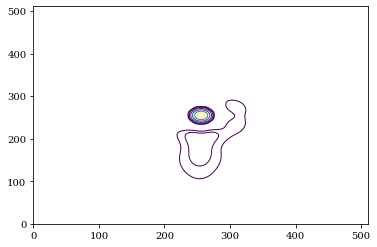

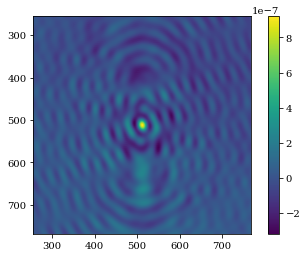

Producing clean visibilities from image with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


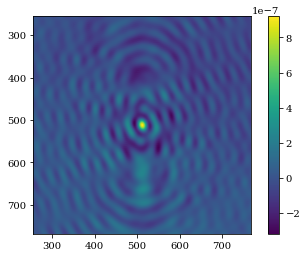

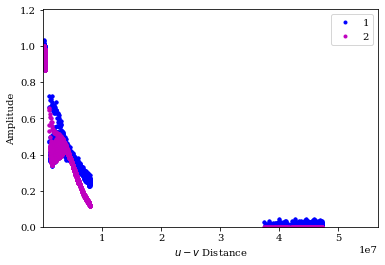

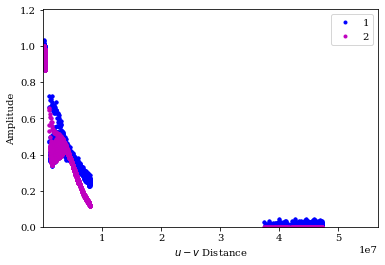

In [15]:
solver.display(psf=False) #contour plot
solver.plot("dmap") #plot residual
solver.plot("fit") #plot current fit to amplitudes

We can threshold the solution to only the significant emission (ignore all noise-like components below 2 percent of the peak value), reinitialize the solver and run the minimization again.

Another powerful method for refining the reconstruction is projecting the current result to positive values only since the Stokes I image can never be negative. Low-level negative fluxes however are produced naturally by the basis functions having some negative flux.

In [16]:
solver.project_to_positive(solver.reco)
solver.project_to_significant(0.01*eh.RADPERAS, level=0.02)

2022-08-05 15:07:20,122 INFO CLEAN                :: Set restored map
2022-08-05 15:07:48,387 INFO CLEAN                :: Set restored map


In [17]:
for i in range(10):
    solver.run(500, recompute_map_list=True)

2022-08-05 15:08:26,984 INFO CLEAN                :: Start running CLEAN with 500 iterations
2022-08-05 15:08:28,152 INFO CountIterations      :: iteration = 1 / 500
2022-08-05 15:08:28,919 INFO CountIterations      :: iteration = 2 / 500
2022-08-05 15:08:29,686 INFO CountIterations      :: iteration = 3 / 500
2022-08-05 15:08:30,453 INFO CountIterations      :: iteration = 4 / 500
2022-08-05 15:08:31,218 INFO CountIterations      :: iteration = 5 / 500
2022-08-05 15:08:31,984 INFO CountIterations      :: iteration = 6 / 500
2022-08-05 15:08:32,752 INFO CountIterations      :: iteration = 7 / 500
2022-08-05 15:08:33,517 INFO CountIterations      :: iteration = 8 / 500
2022-08-05 15:08:34,282 INFO CountIterations      :: iteration = 9 / 500
2022-08-05 15:08:35,061 INFO CountIterations      :: iteration = 10 / 500
2022-08-05 15:08:35,827 INFO CountIterations      :: iteration = 11 / 500
2022-08-05 15:08:36,592 INFO CountIterations      :: iteration = 12 / 500
2022-08-05 15:08:37,358 INFO

2022-08-05 15:09:53,788 INFO CountIterations      :: iteration = 111 / 500
2022-08-05 15:09:54,555 INFO CountIterations      :: iteration = 112 / 500
2022-08-05 15:09:55,314 INFO CountIterations      :: iteration = 113 / 500
2022-08-05 15:09:56,090 INFO CountIterations      :: iteration = 114 / 500
2022-08-05 15:09:56,858 INFO CountIterations      :: iteration = 115 / 500
2022-08-05 15:09:57,613 INFO CountIterations      :: iteration = 116 / 500
2022-08-05 15:09:58,410 INFO CountIterations      :: iteration = 117 / 500
2022-08-05 15:09:59,275 INFO CountIterations      :: iteration = 118 / 500
2022-08-05 15:10:00,042 INFO CountIterations      :: iteration = 119 / 500
2022-08-05 15:10:00,808 INFO CountIterations      :: iteration = 120 / 500
2022-08-05 15:10:01,576 INFO CountIterations      :: iteration = 121 / 500
2022-08-05 15:10:02,342 INFO CountIterations      :: iteration = 122 / 500
2022-08-05 15:10:03,107 INFO CountIterations      :: iteration = 123 / 500
2022-08-05 15:10:03,886 I

2022-08-05 15:11:19,955 INFO CountIterations      :: iteration = 221 / 500
2022-08-05 15:11:20,732 INFO CountIterations      :: iteration = 222 / 500
2022-08-05 15:11:21,575 INFO CountIterations      :: iteration = 223 / 500
2022-08-05 15:11:22,356 INFO CountIterations      :: iteration = 224 / 500
2022-08-05 15:11:23,207 INFO CountIterations      :: iteration = 225 / 500
2022-08-05 15:11:23,962 INFO CountIterations      :: iteration = 226 / 500
2022-08-05 15:11:24,730 INFO CountIterations      :: iteration = 227 / 500
2022-08-05 15:11:25,634 INFO CountIterations      :: iteration = 228 / 500
2022-08-05 15:11:26,422 INFO CountIterations      :: iteration = 229 / 500
2022-08-05 15:11:27,187 INFO CountIterations      :: iteration = 230 / 500
2022-08-05 15:11:27,953 INFO CountIterations      :: iteration = 231 / 500
2022-08-05 15:11:28,720 INFO CountIterations      :: iteration = 232 / 500
2022-08-05 15:11:29,496 INFO CountIterations      :: iteration = 233 / 500
2022-08-05 15:11:30,276 I

2022-08-05 15:12:47,002 INFO CountIterations      :: iteration = 331 / 500
2022-08-05 15:12:47,768 INFO CountIterations      :: iteration = 332 / 500
2022-08-05 15:12:48,528 INFO CountIterations      :: iteration = 333 / 500
2022-08-05 15:12:49,382 INFO CountIterations      :: iteration = 334 / 500
2022-08-05 15:12:50,156 INFO CountIterations      :: iteration = 335 / 500
2022-08-05 15:12:50,923 INFO CountIterations      :: iteration = 336 / 500
2022-08-05 15:12:51,679 INFO CountIterations      :: iteration = 337 / 500
2022-08-05 15:12:52,544 INFO CountIterations      :: iteration = 338 / 500
2022-08-05 15:12:53,312 INFO CountIterations      :: iteration = 339 / 500
2022-08-05 15:12:54,078 INFO CountIterations      :: iteration = 340 / 500
2022-08-05 15:12:54,919 INFO CountIterations      :: iteration = 341 / 500
2022-08-05 15:12:55,688 INFO CountIterations      :: iteration = 342 / 500
2022-08-05 15:12:56,448 INFO CountIterations      :: iteration = 343 / 500
2022-08-05 15:12:57,237 I

2022-08-05 15:14:13,452 INFO CountIterations      :: iteration = 441 / 500
2022-08-05 15:14:14,220 INFO CountIterations      :: iteration = 442 / 500
2022-08-05 15:14:14,987 INFO CountIterations      :: iteration = 443 / 500
2022-08-05 15:14:15,752 INFO CountIterations      :: iteration = 444 / 500
2022-08-05 15:14:16,521 INFO CountIterations      :: iteration = 445 / 500
2022-08-05 15:14:17,386 INFO CountIterations      :: iteration = 446 / 500
2022-08-05 15:14:18,204 INFO CountIterations      :: iteration = 447 / 500
2022-08-05 15:14:18,967 INFO CountIterations      :: iteration = 448 / 500
2022-08-05 15:14:19,730 INFO CountIterations      :: iteration = 449 / 500
2022-08-05 15:14:20,493 INFO CountIterations      :: iteration = 450 / 500
2022-08-05 15:14:21,340 INFO CountIterations      :: iteration = 451 / 500
2022-08-05 15:14:22,102 INFO CountIterations      :: iteration = 452 / 500
2022-08-05 15:14:22,865 INFO CountIterations      :: iteration = 453 / 500
2022-08-05 15:14:23,633 I

2022-08-05 15:16:14,440 INFO CountIterations      :: iteration = 41 / 500
2022-08-05 15:16:14,901 INFO CountIterations      :: iteration = 42 / 500
2022-08-05 15:16:15,366 INFO CountIterations      :: iteration = 43 / 500
2022-08-05 15:16:15,907 INFO CountIterations      :: iteration = 44 / 500
2022-08-05 15:16:16,360 INFO CountIterations      :: iteration = 45 / 500
2022-08-05 15:16:16,829 INFO CountIterations      :: iteration = 46 / 500
2022-08-05 15:16:17,298 INFO CountIterations      :: iteration = 47 / 500
2022-08-05 15:16:17,752 INFO CountIterations      :: iteration = 48 / 500
2022-08-05 15:16:18,222 INFO CountIterations      :: iteration = 49 / 500
2022-08-05 15:16:18,689 INFO CountIterations      :: iteration = 50 / 500
2022-08-05 15:16:19,145 INFO CountIterations      :: iteration = 51 / 500
2022-08-05 15:16:19,614 INFO CountIterations      :: iteration = 52 / 500
2022-08-05 15:16:20,080 INFO CountIterations      :: iteration = 53 / 500
2022-08-05 15:16:20,535 INFO CountIter

2022-08-05 15:17:06,691 INFO CountIterations      :: iteration = 152 / 500
2022-08-05 15:17:07,163 INFO CountIterations      :: iteration = 153 / 500
2022-08-05 15:17:07,617 INFO CountIterations      :: iteration = 154 / 500
2022-08-05 15:17:08,086 INFO CountIterations      :: iteration = 155 / 500
2022-08-05 15:17:08,552 INFO CountIterations      :: iteration = 156 / 500
2022-08-05 15:17:09,006 INFO CountIterations      :: iteration = 157 / 500
2022-08-05 15:17:09,475 INFO CountIterations      :: iteration = 158 / 500
2022-08-05 15:17:09,942 INFO CountIterations      :: iteration = 159 / 500
2022-08-05 15:17:10,397 INFO CountIterations      :: iteration = 160 / 500
2022-08-05 15:17:10,865 INFO CountIterations      :: iteration = 161 / 500
2022-08-05 15:17:11,333 INFO CountIterations      :: iteration = 162 / 500
2022-08-05 15:17:11,788 INFO CountIterations      :: iteration = 163 / 500
2022-08-05 15:17:12,256 INFO CountIterations      :: iteration = 164 / 500
2022-08-05 15:17:12,744 I

2022-08-05 15:17:57,547 INFO CountIterations      :: iteration = 262 / 500
2022-08-05 15:17:57,982 INFO CountIterations      :: iteration = 263 / 500
2022-08-05 15:17:58,432 INFO CountIterations      :: iteration = 264 / 500
2022-08-05 15:17:58,882 INFO CountIterations      :: iteration = 265 / 500
2022-08-05 15:17:59,318 INFO CountIterations      :: iteration = 266 / 500
2022-08-05 15:17:59,768 INFO CountIterations      :: iteration = 267 / 500
2022-08-05 15:18:00,204 INFO CountIterations      :: iteration = 268 / 500
2022-08-05 15:18:00,654 INFO CountIterations      :: iteration = 269 / 500
2022-08-05 15:18:01,121 INFO CountIterations      :: iteration = 270 / 500
2022-08-05 15:18:01,562 INFO CountIterations      :: iteration = 271 / 500
2022-08-05 15:18:02,048 INFO CountIterations      :: iteration = 272 / 500
2022-08-05 15:18:02,497 INFO CountIterations      :: iteration = 273 / 500
2022-08-05 15:18:02,947 INFO CountIterations      :: iteration = 274 / 500
2022-08-05 15:18:03,383 I

2022-08-05 15:18:47,137 INFO CountIterations      :: iteration = 372 / 500
2022-08-05 15:18:47,585 INFO CountIterations      :: iteration = 373 / 500
2022-08-05 15:18:48,029 INFO CountIterations      :: iteration = 374 / 500
2022-08-05 15:18:48,462 INFO CountIterations      :: iteration = 375 / 500
2022-08-05 15:18:48,906 INFO CountIterations      :: iteration = 376 / 500
2022-08-05 15:18:49,349 INFO CountIterations      :: iteration = 377 / 500
2022-08-05 15:18:49,783 INFO CountIterations      :: iteration = 378 / 500
2022-08-05 15:18:50,226 INFO CountIterations      :: iteration = 379 / 500
2022-08-05 15:18:50,659 INFO CountIterations      :: iteration = 380 / 500
2022-08-05 15:18:51,098 INFO CountIterations      :: iteration = 381 / 500
2022-08-05 15:18:51,593 INFO CountIterations      :: iteration = 382 / 500
2022-08-05 15:18:52,036 INFO CountIterations      :: iteration = 383 / 500
2022-08-05 15:18:52,544 INFO CountIterations      :: iteration = 384 / 500
2022-08-05 15:18:53,005 I

2022-08-05 15:19:37,129 INFO CountIterations      :: iteration = 482 / 500
2022-08-05 15:19:37,568 INFO CountIterations      :: iteration = 483 / 500
2022-08-05 15:19:38,023 INFO CountIterations      :: iteration = 484 / 500
2022-08-05 15:19:38,473 INFO CountIterations      :: iteration = 485 / 500
2022-08-05 15:19:38,910 INFO CountIterations      :: iteration = 486 / 500
2022-08-05 15:19:39,359 INFO CountIterations      :: iteration = 487 / 500
2022-08-05 15:19:39,810 INFO CountIterations      :: iteration = 488 / 500
2022-08-05 15:19:40,249 INFO CountIterations      :: iteration = 489 / 500
2022-08-05 15:19:40,692 INFO CountIterations      :: iteration = 490 / 500
2022-08-05 15:19:41,193 INFO CountIterations      :: iteration = 491 / 500
2022-08-05 15:19:41,642 INFO CountIterations      :: iteration = 492 / 500
2022-08-05 15:19:42,095 INFO CountIterations      :: iteration = 493 / 500
2022-08-05 15:19:42,553 INFO CountIterations      :: iteration = 494 / 500
2022-08-05 15:19:42,991 I

2022-08-05 15:21:25,815 INFO CountIterations      :: iteration = 83 / 500
2022-08-05 15:21:26,584 INFO CountIterations      :: iteration = 84 / 500
2022-08-05 15:21:27,349 INFO CountIterations      :: iteration = 85 / 500
2022-08-05 15:21:28,117 INFO CountIterations      :: iteration = 86 / 500
2022-08-05 15:21:28,885 INFO CountIterations      :: iteration = 87 / 500
2022-08-05 15:21:29,647 INFO CountIterations      :: iteration = 88 / 500
2022-08-05 15:21:30,504 INFO CountIterations      :: iteration = 89 / 500
2022-08-05 15:21:31,272 INFO CountIterations      :: iteration = 90 / 500
2022-08-05 15:21:32,070 INFO CountIterations      :: iteration = 91 / 500
2022-08-05 15:21:32,826 INFO CountIterations      :: iteration = 92 / 500
2022-08-05 15:21:33,653 INFO CountIterations      :: iteration = 93 / 500
2022-08-05 15:21:34,501 INFO CountIterations      :: iteration = 94 / 500
2022-08-05 15:21:35,258 INFO CountIterations      :: iteration = 95 / 500
2022-08-05 15:21:36,035 INFO CountIter

2022-08-05 15:22:49,690 INFO CountIterations      :: iteration = 193 / 500
2022-08-05 15:22:50,406 INFO CountIterations      :: iteration = 194 / 500
2022-08-05 15:22:51,127 INFO CountIterations      :: iteration = 195 / 500
2022-08-05 15:22:51,850 INFO CountIterations      :: iteration = 196 / 500
2022-08-05 15:22:52,568 INFO CountIterations      :: iteration = 197 / 500
2022-08-05 15:22:53,294 INFO CountIterations      :: iteration = 198 / 500
2022-08-05 15:22:54,013 INFO CountIterations      :: iteration = 199 / 500
2022-08-05 15:22:54,719 INFO CountIterations      :: iteration = 200 / 500
2022-08-05 15:22:55,496 INFO CountIterations      :: iteration = 201 / 500
2022-08-05 15:22:56,352 INFO CountIterations      :: iteration = 202 / 500
2022-08-05 15:22:57,070 INFO CountIterations      :: iteration = 203 / 500
2022-08-05 15:22:57,787 INFO CountIterations      :: iteration = 204 / 500
2022-08-05 15:22:58,505 INFO CountIterations      :: iteration = 205 / 500
2022-08-05 15:22:59,220 I

2022-08-05 15:24:13,065 INFO CountIterations      :: iteration = 303 / 500
2022-08-05 15:24:13,809 INFO CountIterations      :: iteration = 304 / 500
2022-08-05 15:24:14,556 INFO CountIterations      :: iteration = 305 / 500
2022-08-05 15:24:15,298 INFO CountIterations      :: iteration = 306 / 500
2022-08-05 15:24:16,042 INFO CountIterations      :: iteration = 307 / 500
2022-08-05 15:24:16,782 INFO CountIterations      :: iteration = 308 / 500
2022-08-05 15:24:17,524 INFO CountIterations      :: iteration = 309 / 500
2022-08-05 15:24:18,263 INFO CountIterations      :: iteration = 310 / 500
2022-08-05 15:24:19,002 INFO CountIterations      :: iteration = 311 / 500
2022-08-05 15:24:19,745 INFO CountIterations      :: iteration = 312 / 500
2022-08-05 15:24:20,571 INFO CountIterations      :: iteration = 313 / 500
2022-08-05 15:24:21,311 INFO CountIterations      :: iteration = 314 / 500
2022-08-05 15:24:22,129 INFO CountIterations      :: iteration = 315 / 500
2022-08-05 15:24:22,878 I

2022-08-05 15:25:38,827 INFO CountIterations      :: iteration = 413 / 500
2022-08-05 15:25:39,661 INFO CountIterations      :: iteration = 414 / 500
2022-08-05 15:25:40,489 INFO CountIterations      :: iteration = 415 / 500
2022-08-05 15:25:41,236 INFO CountIterations      :: iteration = 416 / 500
2022-08-05 15:25:41,985 INFO CountIterations      :: iteration = 417 / 500
2022-08-05 15:25:42,733 INFO CountIterations      :: iteration = 418 / 500
2022-08-05 15:25:43,486 INFO CountIterations      :: iteration = 419 / 500
2022-08-05 15:25:44,239 INFO CountIterations      :: iteration = 420 / 500
2022-08-05 15:25:44,990 INFO CountIterations      :: iteration = 421 / 500
2022-08-05 15:25:45,818 INFO CountIterations      :: iteration = 422 / 500
2022-08-05 15:25:46,599 INFO CountIterations      :: iteration = 423 / 500
2022-08-05 15:25:47,354 INFO CountIterations      :: iteration = 424 / 500
2022-08-05 15:25:48,109 INFO CountIterations      :: iteration = 425 / 500
2022-08-05 15:25:48,911 I

2022-08-05 15:27:48,911 INFO CountIterations      :: iteration = 13 / 500
2022-08-05 15:27:49,697 INFO CountIterations      :: iteration = 14 / 500
2022-08-05 15:27:50,544 INFO CountIterations      :: iteration = 15 / 500
2022-08-05 15:27:51,317 INFO CountIterations      :: iteration = 16 / 500
2022-08-05 15:27:52,077 INFO CountIterations      :: iteration = 17 / 500
2022-08-05 15:27:52,839 INFO CountIterations      :: iteration = 18 / 500
2022-08-05 15:27:53,624 INFO CountIterations      :: iteration = 19 / 500
2022-08-05 15:27:54,433 INFO CountIterations      :: iteration = 20 / 500
2022-08-05 15:27:55,191 INFO CountIterations      :: iteration = 21 / 500
2022-08-05 15:27:55,947 INFO CountIterations      :: iteration = 22 / 500
2022-08-05 15:27:56,703 INFO CountIterations      :: iteration = 23 / 500
2022-08-05 15:27:57,563 INFO CountIterations      :: iteration = 24 / 500
2022-08-05 15:27:58,407 INFO CountIterations      :: iteration = 25 / 500
2022-08-05 15:27:59,159 INFO CountIter

2022-08-05 15:29:15,381 INFO CountIterations      :: iteration = 124 / 500
2022-08-05 15:29:16,241 INFO CountIterations      :: iteration = 125 / 500
2022-08-05 15:29:17,008 INFO CountIterations      :: iteration = 126 / 500
2022-08-05 15:29:17,762 INFO CountIterations      :: iteration = 127 / 500
2022-08-05 15:29:18,558 INFO CountIterations      :: iteration = 128 / 500
2022-08-05 15:29:19,397 INFO CountIterations      :: iteration = 129 / 500
2022-08-05 15:29:20,160 INFO CountIterations      :: iteration = 130 / 500
2022-08-05 15:29:20,923 INFO CountIterations      :: iteration = 131 / 500
2022-08-05 15:29:21,686 INFO CountIterations      :: iteration = 132 / 500
2022-08-05 15:29:22,447 INFO CountIterations      :: iteration = 133 / 500
2022-08-05 15:29:23,210 INFO CountIterations      :: iteration = 134 / 500
2022-08-05 15:29:23,972 INFO CountIterations      :: iteration = 135 / 500
2022-08-05 15:29:24,733 INFO CountIterations      :: iteration = 136 / 500
2022-08-05 15:29:25,497 I

2022-08-05 15:30:41,386 INFO CountIterations      :: iteration = 234 / 500
2022-08-05 15:30:42,141 INFO CountIterations      :: iteration = 235 / 500
2022-08-05 15:30:42,905 INFO CountIterations      :: iteration = 236 / 500
2022-08-05 15:30:43,662 INFO CountIterations      :: iteration = 237 / 500
2022-08-05 15:30:44,511 INFO CountIterations      :: iteration = 238 / 500
2022-08-05 15:30:45,264 INFO CountIterations      :: iteration = 239 / 500
2022-08-05 15:30:46,021 INFO CountIterations      :: iteration = 240 / 500
2022-08-05 15:30:46,772 INFO CountIterations      :: iteration = 241 / 500
2022-08-05 15:30:47,609 INFO CountIterations      :: iteration = 242 / 500
2022-08-05 15:30:48,370 INFO CountIterations      :: iteration = 243 / 500
2022-08-05 15:30:49,127 INFO CountIterations      :: iteration = 244 / 500
2022-08-05 15:30:49,886 INFO CountIterations      :: iteration = 245 / 500
2022-08-05 15:30:50,634 INFO CountIterations      :: iteration = 246 / 500
2022-08-05 15:30:51,405 I

2022-08-05 15:32:07,338 INFO CountIterations      :: iteration = 344 / 500
2022-08-05 15:32:08,132 INFO CountIterations      :: iteration = 345 / 500
2022-08-05 15:32:08,916 INFO CountIterations      :: iteration = 346 / 500
2022-08-05 15:32:09,803 INFO CountIterations      :: iteration = 347 / 500
2022-08-05 15:32:10,605 INFO CountIterations      :: iteration = 348 / 500
2022-08-05 15:32:11,368 INFO CountIterations      :: iteration = 349 / 500
2022-08-05 15:32:12,117 INFO CountIterations      :: iteration = 350 / 500
2022-08-05 15:32:12,909 INFO CountIterations      :: iteration = 351 / 500
2022-08-05 15:32:13,774 INFO CountIterations      :: iteration = 352 / 500
2022-08-05 15:32:14,535 INFO CountIterations      :: iteration = 353 / 500
2022-08-05 15:32:15,296 INFO CountIterations      :: iteration = 354 / 500
2022-08-05 15:32:16,060 INFO CountIterations      :: iteration = 355 / 500
2022-08-05 15:32:16,926 INFO CountIterations      :: iteration = 356 / 500
2022-08-05 15:32:17,686 I

2022-08-05 15:33:33,444 INFO CountIterations      :: iteration = 454 / 500
2022-08-05 15:33:34,230 INFO CountIterations      :: iteration = 455 / 500
2022-08-05 15:33:34,991 INFO CountIterations      :: iteration = 456 / 500
2022-08-05 15:33:35,764 INFO CountIterations      :: iteration = 457 / 500
2022-08-05 15:33:36,526 INFO CountIterations      :: iteration = 458 / 500
2022-08-05 15:33:37,286 INFO CountIterations      :: iteration = 459 / 500
2022-08-05 15:33:38,045 INFO CountIterations      :: iteration = 460 / 500
2022-08-05 15:33:38,804 INFO CountIterations      :: iteration = 461 / 500
2022-08-05 15:33:39,565 INFO CountIterations      :: iteration = 462 / 500
2022-08-05 15:33:40,319 INFO CountIterations      :: iteration = 463 / 500
2022-08-05 15:33:41,084 INFO CountIterations      :: iteration = 464 / 500
2022-08-05 15:33:41,929 INFO CountIterations      :: iteration = 465 / 500
2022-08-05 15:33:42,690 INFO CountIterations      :: iteration = 466 / 500
2022-08-05 15:33:43,506 I

2022-08-05 15:35:27,974 INFO CountIterations      :: iteration = 54 / 500
2022-08-05 15:35:28,499 INFO CountIterations      :: iteration = 55 / 500
2022-08-05 15:35:28,971 INFO CountIterations      :: iteration = 56 / 500
2022-08-05 15:35:29,427 INFO CountIterations      :: iteration = 57 / 500
2022-08-05 15:35:29,896 INFO CountIterations      :: iteration = 58 / 500
2022-08-05 15:35:30,351 INFO CountIterations      :: iteration = 59 / 500
2022-08-05 15:35:30,820 INFO CountIterations      :: iteration = 60 / 500
2022-08-05 15:35:31,287 INFO CountIterations      :: iteration = 61 / 500
2022-08-05 15:35:31,742 INFO CountIterations      :: iteration = 62 / 500
2022-08-05 15:35:32,211 INFO CountIterations      :: iteration = 63 / 500
2022-08-05 15:35:32,678 INFO CountIterations      :: iteration = 64 / 500
2022-08-05 15:35:33,133 INFO CountIterations      :: iteration = 65 / 500
2022-08-05 15:35:33,603 INFO CountIterations      :: iteration = 66 / 500
2022-08-05 15:35:34,072 INFO CountIter

2022-08-05 15:36:20,091 INFO CountIterations      :: iteration = 164 / 500
2022-08-05 15:36:20,532 INFO CountIterations      :: iteration = 165 / 500
2022-08-05 15:36:20,987 INFO CountIterations      :: iteration = 166 / 500
2022-08-05 15:36:21,425 INFO CountIterations      :: iteration = 167 / 500
2022-08-05 15:36:21,881 INFO CountIterations      :: iteration = 168 / 500
2022-08-05 15:36:22,334 INFO CountIterations      :: iteration = 169 / 500
2022-08-05 15:36:22,773 INFO CountIterations      :: iteration = 170 / 500
2022-08-05 15:36:23,225 INFO CountIterations      :: iteration = 171 / 500
2022-08-05 15:36:23,676 INFO CountIterations      :: iteration = 172 / 500
2022-08-05 15:36:24,115 INFO CountIterations      :: iteration = 173 / 500
2022-08-05 15:36:24,566 INFO CountIterations      :: iteration = 174 / 500
2022-08-05 15:36:25,004 INFO CountIterations      :: iteration = 175 / 500
2022-08-05 15:36:25,456 INFO CountIterations      :: iteration = 176 / 500
2022-08-05 15:36:25,905 I

2022-08-05 15:37:09,925 INFO CountIterations      :: iteration = 274 / 500
2022-08-05 15:37:10,454 INFO CountIterations      :: iteration = 275 / 500
2022-08-05 15:37:10,887 INFO CountIterations      :: iteration = 276 / 500
2022-08-05 15:37:11,413 INFO CountIterations      :: iteration = 277 / 500
2022-08-05 15:37:11,847 INFO CountIterations      :: iteration = 278 / 500
2022-08-05 15:37:12,293 INFO CountIterations      :: iteration = 279 / 500
2022-08-05 15:37:12,811 INFO CountIterations      :: iteration = 280 / 500
2022-08-05 15:37:13,244 INFO CountIterations      :: iteration = 281 / 500
2022-08-05 15:37:13,691 INFO CountIterations      :: iteration = 282 / 500
2022-08-05 15:37:14,124 INFO CountIterations      :: iteration = 283 / 500
2022-08-05 15:37:14,570 INFO CountIterations      :: iteration = 284 / 500
2022-08-05 15:37:15,015 INFO CountIterations      :: iteration = 285 / 500
2022-08-05 15:37:15,466 INFO CountIterations      :: iteration = 286 / 500
2022-08-05 15:37:15,913 I

2022-08-05 15:38:00,312 INFO CountIterations      :: iteration = 384 / 500
2022-08-05 15:38:00,772 INFO CountIterations      :: iteration = 385 / 500
2022-08-05 15:38:01,222 INFO CountIterations      :: iteration = 386 / 500
2022-08-05 15:38:01,664 INFO CountIterations      :: iteration = 387 / 500
2022-08-05 15:38:02,127 INFO CountIterations      :: iteration = 388 / 500
2022-08-05 15:38:02,594 INFO CountIterations      :: iteration = 389 / 500
2022-08-05 15:38:03,105 INFO CountIterations      :: iteration = 390 / 500
2022-08-05 15:38:03,592 INFO CountIterations      :: iteration = 391 / 500
2022-08-05 15:38:04,072 INFO CountIterations      :: iteration = 392 / 500
2022-08-05 15:38:04,511 INFO CountIterations      :: iteration = 393 / 500
2022-08-05 15:38:04,965 INFO CountIterations      :: iteration = 394 / 500
2022-08-05 15:38:05,418 INFO CountIterations      :: iteration = 395 / 500
2022-08-05 15:38:05,857 INFO CountIterations      :: iteration = 396 / 500
2022-08-05 15:38:06,311 I

2022-08-05 15:38:50,614 INFO CountIterations      :: iteration = 494 / 500
2022-08-05 15:38:51,051 INFO CountIterations      :: iteration = 495 / 500
2022-08-05 15:38:51,494 INFO CountIterations      :: iteration = 496 / 500
2022-08-05 15:38:51,955 INFO CountIterations      :: iteration = 497 / 500
2022-08-05 15:38:52,396 INFO CountIterations      :: iteration = 498 / 500
2022-08-05 15:38:52,846 INFO CountIterations      :: iteration = 499 / 500
2022-08-05 15:38:53,287 INFO CountIterations      :: iteration = 500 / 500
2022-08-05 15:38:53,288 INFO HybridCLEAN          :: Stopping rule triggered.
2022-08-05 15:38:53,289 INFO CLEAN                :: Stop running CLEAN
2022-08-05 15:38:53,289 INFO CLEAN                :: Convolve with psf
2022-08-05 15:38:53,290 INFO CLEAN                :: Merge component list
2022-08-05 15:38:53,290 INFO CLEAN                :: Merge component list
2022-08-05 15:39:00,311 INFO CLEAN                :: Solver finished
2022-08-05 15:39:00,329 INFO CLEAN   

2022-08-05 15:40:43,821 INFO CountIterations      :: iteration = 95 / 500
2022-08-05 15:40:44,657 INFO CountIterations      :: iteration = 96 / 500
2022-08-05 15:40:45,523 INFO CountIterations      :: iteration = 97 / 500
2022-08-05 15:40:46,288 INFO CountIterations      :: iteration = 98 / 500
2022-08-05 15:40:47,071 INFO CountIterations      :: iteration = 99 / 500
2022-08-05 15:40:47,841 INFO CountIterations      :: iteration = 100 / 500
2022-08-05 15:40:48,608 INFO CountIterations      :: iteration = 101 / 500
2022-08-05 15:40:49,373 INFO CountIterations      :: iteration = 102 / 500
2022-08-05 15:40:50,138 INFO CountIterations      :: iteration = 103 / 500
2022-08-05 15:40:50,934 INFO CountIterations      :: iteration = 104 / 500
2022-08-05 15:40:51,713 INFO CountIterations      :: iteration = 105 / 500
2022-08-05 15:40:52,478 INFO CountIterations      :: iteration = 106 / 500
2022-08-05 15:40:53,243 INFO CountIterations      :: iteration = 107 / 500
2022-08-05 15:40:54,022 INFO C

2022-08-05 15:42:10,602 INFO CountIterations      :: iteration = 205 / 500
2022-08-05 15:42:11,404 INFO CountIterations      :: iteration = 206 / 500
2022-08-05 15:42:12,164 INFO CountIterations      :: iteration = 207 / 500
2022-08-05 15:42:12,921 INFO CountIterations      :: iteration = 208 / 500
2022-08-05 15:42:13,676 INFO CountIterations      :: iteration = 209 / 500
2022-08-05 15:42:14,440 INFO CountIterations      :: iteration = 210 / 500
2022-08-05 15:42:15,304 INFO CountIterations      :: iteration = 211 / 500
2022-08-05 15:42:16,144 INFO CountIterations      :: iteration = 212 / 500
2022-08-05 15:42:16,973 INFO CountIterations      :: iteration = 213 / 500
2022-08-05 15:42:17,748 INFO CountIterations      :: iteration = 214 / 500
2022-08-05 15:42:18,589 INFO CountIterations      :: iteration = 215 / 500
2022-08-05 15:42:19,435 INFO CountIterations      :: iteration = 216 / 500
2022-08-05 15:42:20,197 INFO CountIterations      :: iteration = 217 / 500
2022-08-05 15:42:20,971 I

2022-08-05 15:43:37,207 INFO CountIterations      :: iteration = 315 / 500
2022-08-05 15:43:37,970 INFO CountIterations      :: iteration = 316 / 500
2022-08-05 15:43:38,738 INFO CountIterations      :: iteration = 317 / 500
2022-08-05 15:43:39,510 INFO CountIterations      :: iteration = 318 / 500
2022-08-05 15:43:40,278 INFO CountIterations      :: iteration = 319 / 500
2022-08-05 15:43:41,045 INFO CountIterations      :: iteration = 320 / 500
2022-08-05 15:43:41,831 INFO CountIterations      :: iteration = 321 / 500
2022-08-05 15:43:42,684 INFO CountIterations      :: iteration = 322 / 500
2022-08-05 15:43:43,537 INFO CountIterations      :: iteration = 323 / 500
2022-08-05 15:43:44,370 INFO CountIterations      :: iteration = 324 / 500
2022-08-05 15:43:45,141 INFO CountIterations      :: iteration = 325 / 500
2022-08-05 15:43:45,907 INFO CountIterations      :: iteration = 326 / 500
2022-08-05 15:43:46,759 INFO CountIterations      :: iteration = 327 / 500
2022-08-05 15:43:47,539 I

2022-08-05 15:45:04,286 INFO CountIterations      :: iteration = 425 / 500
2022-08-05 15:45:05,131 INFO CountIterations      :: iteration = 426 / 500
2022-08-05 15:45:05,894 INFO CountIterations      :: iteration = 427 / 500
2022-08-05 15:45:06,667 INFO CountIterations      :: iteration = 428 / 500
2022-08-05 15:45:07,433 INFO CountIterations      :: iteration = 429 / 500
2022-08-05 15:45:08,208 INFO CountIterations      :: iteration = 430 / 500
2022-08-05 15:45:08,975 INFO CountIterations      :: iteration = 431 / 500
2022-08-05 15:45:09,732 INFO CountIterations      :: iteration = 432 / 500
2022-08-05 15:45:10,587 INFO CountIterations      :: iteration = 433 / 500
2022-08-05 15:45:11,358 INFO CountIterations      :: iteration = 434 / 500
2022-08-05 15:45:12,216 INFO CountIterations      :: iteration = 435 / 500
2022-08-05 15:45:13,059 INFO CountIterations      :: iteration = 436 / 500
2022-08-05 15:45:13,851 INFO CountIterations      :: iteration = 437 / 500
2022-08-05 15:45:14,646 I

2022-08-05 15:47:12,996 INFO CountIterations      :: iteration = 25 / 500
2022-08-05 15:47:13,749 INFO CountIterations      :: iteration = 26 / 500
2022-08-05 15:47:14,528 INFO CountIterations      :: iteration = 27 / 500
2022-08-05 15:47:15,311 INFO CountIterations      :: iteration = 28 / 500
2022-08-05 15:47:16,067 INFO CountIterations      :: iteration = 29 / 500
2022-08-05 15:47:16,822 INFO CountIterations      :: iteration = 30 / 500
2022-08-05 15:47:17,652 INFO CountIterations      :: iteration = 31 / 500
2022-08-05 15:47:18,503 INFO CountIterations      :: iteration = 32 / 500
2022-08-05 15:47:19,270 INFO CountIterations      :: iteration = 33 / 500
2022-08-05 15:47:20,034 INFO CountIterations      :: iteration = 34 / 500
2022-08-05 15:47:20,801 INFO CountIterations      :: iteration = 35 / 500
2022-08-05 15:47:21,591 INFO CountIterations      :: iteration = 36 / 500
2022-08-05 15:47:22,355 INFO CountIterations      :: iteration = 37 / 500
2022-08-05 15:47:23,134 INFO CountIter

2022-08-05 15:48:39,901 INFO CountIterations      :: iteration = 136 / 500
2022-08-05 15:48:40,681 INFO CountIterations      :: iteration = 137 / 500
2022-08-05 15:48:41,446 INFO CountIterations      :: iteration = 138 / 500
2022-08-05 15:48:42,209 INFO CountIterations      :: iteration = 139 / 500
2022-08-05 15:48:42,972 INFO CountIterations      :: iteration = 140 / 500
2022-08-05 15:48:43,814 INFO CountIterations      :: iteration = 141 / 500
2022-08-05 15:48:44,569 INFO CountIterations      :: iteration = 142 / 500
2022-08-05 15:48:45,328 INFO CountIterations      :: iteration = 143 / 500
2022-08-05 15:48:46,176 INFO CountIterations      :: iteration = 144 / 500
2022-08-05 15:48:46,941 INFO CountIterations      :: iteration = 145 / 500
2022-08-05 15:48:47,784 INFO CountIterations      :: iteration = 146 / 500
2022-08-05 15:48:48,628 INFO CountIterations      :: iteration = 147 / 500
2022-08-05 15:48:49,385 INFO CountIterations      :: iteration = 148 / 500
2022-08-05 15:48:50,140 I

2022-08-05 15:50:06,382 INFO CountIterations      :: iteration = 246 / 500
2022-08-05 15:50:07,227 INFO CountIterations      :: iteration = 247 / 500
2022-08-05 15:50:08,013 INFO CountIterations      :: iteration = 248 / 500
2022-08-05 15:50:08,778 INFO CountIterations      :: iteration = 249 / 500
2022-08-05 15:50:09,618 INFO CountIterations      :: iteration = 250 / 500
2022-08-05 15:50:10,371 INFO CountIterations      :: iteration = 251 / 500
2022-08-05 15:50:11,234 INFO CountIterations      :: iteration = 252 / 500
2022-08-05 15:50:12,082 INFO CountIterations      :: iteration = 253 / 500
2022-08-05 15:50:12,835 INFO CountIterations      :: iteration = 254 / 500
2022-08-05 15:50:13,682 INFO CountIterations      :: iteration = 255 / 500
2022-08-05 15:50:14,533 INFO CountIterations      :: iteration = 256 / 500
2022-08-05 15:50:15,300 INFO CountIterations      :: iteration = 257 / 500
2022-08-05 15:50:16,060 INFO CountIterations      :: iteration = 258 / 500
2022-08-05 15:50:16,836 I

2022-08-05 15:51:33,511 INFO CountIterations      :: iteration = 356 / 500
2022-08-05 15:51:34,365 INFO CountIterations      :: iteration = 357 / 500
2022-08-05 15:51:35,249 INFO CountIterations      :: iteration = 358 / 500
2022-08-05 15:51:36,016 INFO CountIterations      :: iteration = 359 / 500
2022-08-05 15:51:36,772 INFO CountIterations      :: iteration = 360 / 500
2022-08-05 15:51:37,527 INFO CountIterations      :: iteration = 361 / 500
2022-08-05 15:51:38,314 INFO CountIterations      :: iteration = 362 / 500
2022-08-05 15:51:39,074 INFO CountIterations      :: iteration = 363 / 500
2022-08-05 15:51:39,848 INFO CountIterations      :: iteration = 364 / 500
2022-08-05 15:51:40,657 INFO CountIterations      :: iteration = 365 / 500
2022-08-05 15:51:41,614 INFO CountIterations      :: iteration = 366 / 500
2022-08-05 15:51:42,381 INFO CountIterations      :: iteration = 367 / 500
2022-08-05 15:51:43,144 INFO CountIterations      :: iteration = 368 / 500
2022-08-05 15:51:43,909 I

2022-08-05 15:53:00,458 INFO CountIterations      :: iteration = 466 / 500
2022-08-05 15:53:01,287 INFO CountIterations      :: iteration = 467 / 500
2022-08-05 15:53:02,138 INFO CountIterations      :: iteration = 468 / 500
2022-08-05 15:53:02,988 INFO CountIterations      :: iteration = 469 / 500
2022-08-05 15:53:03,778 INFO CountIterations      :: iteration = 470 / 500
2022-08-05 15:53:04,541 INFO CountIterations      :: iteration = 471 / 500
2022-08-05 15:53:05,319 INFO CountIterations      :: iteration = 472 / 500
2022-08-05 15:53:06,096 INFO CountIterations      :: iteration = 473 / 500
2022-08-05 15:53:06,860 INFO CountIterations      :: iteration = 474 / 500
2022-08-05 15:53:07,626 INFO CountIterations      :: iteration = 475 / 500
2022-08-05 15:53:08,391 INFO CountIterations      :: iteration = 476 / 500
2022-08-05 15:53:09,156 INFO CountIterations      :: iteration = 477 / 500
2022-08-05 15:53:10,014 INFO CountIterations      :: iteration = 478 / 500
2022-08-05 15:53:10,861 I

2022-08-05 15:54:52,828 INFO CountIterations      :: iteration = 66 / 500
2022-08-05 15:54:53,285 INFO CountIterations      :: iteration = 67 / 500
2022-08-05 15:54:53,743 INFO CountIterations      :: iteration = 68 / 500
2022-08-05 15:54:54,199 INFO CountIterations      :: iteration = 69 / 500
2022-08-05 15:54:54,657 INFO CountIterations      :: iteration = 70 / 500
2022-08-05 15:54:55,125 INFO CountIterations      :: iteration = 71 / 500
2022-08-05 15:54:55,663 INFO CountIterations      :: iteration = 72 / 500
2022-08-05 15:54:56,121 INFO CountIterations      :: iteration = 73 / 500
2022-08-05 15:54:56,588 INFO CountIterations      :: iteration = 74 / 500
2022-08-05 15:54:57,062 INFO CountIterations      :: iteration = 75 / 500
2022-08-05 15:54:57,518 INFO CountIterations      :: iteration = 76 / 500
2022-08-05 15:54:57,988 INFO CountIterations      :: iteration = 77 / 500
2022-08-05 15:54:58,459 INFO CountIterations      :: iteration = 78 / 500
2022-08-05 15:54:58,916 INFO CountIter

2022-08-05 15:55:45,155 INFO CountIterations      :: iteration = 176 / 500
2022-08-05 15:55:45,624 INFO CountIterations      :: iteration = 177 / 500
2022-08-05 15:55:46,083 INFO CountIterations      :: iteration = 178 / 500
2022-08-05 15:55:46,543 INFO CountIterations      :: iteration = 179 / 500
2022-08-05 15:55:47,002 INFO CountIterations      :: iteration = 180 / 500
2022-08-05 15:55:47,469 INFO CountIterations      :: iteration = 181 / 500
2022-08-05 15:55:47,958 INFO CountIterations      :: iteration = 182 / 500
2022-08-05 15:55:48,422 INFO CountIterations      :: iteration = 183 / 500
2022-08-05 15:55:48,952 INFO CountIterations      :: iteration = 184 / 500
2022-08-05 15:55:49,454 INFO CountIterations      :: iteration = 185 / 500
2022-08-05 15:55:49,927 INFO CountIterations      :: iteration = 186 / 500
2022-08-05 15:55:50,382 INFO CountIterations      :: iteration = 187 / 500
2022-08-05 15:55:50,855 INFO CountIterations      :: iteration = 188 / 500
2022-08-05 15:55:51,330 I

2022-08-05 15:56:37,708 INFO CountIterations      :: iteration = 286 / 500
2022-08-05 15:56:38,167 INFO CountIterations      :: iteration = 287 / 500
2022-08-05 15:56:38,629 INFO CountIterations      :: iteration = 288 / 500
2022-08-05 15:56:39,165 INFO CountIterations      :: iteration = 289 / 500
2022-08-05 15:56:39,622 INFO CountIterations      :: iteration = 290 / 500
2022-08-05 15:56:40,078 INFO CountIterations      :: iteration = 291 / 500
2022-08-05 15:56:40,621 INFO CountIterations      :: iteration = 292 / 500
2022-08-05 15:56:41,076 INFO CountIterations      :: iteration = 293 / 500
2022-08-05 15:56:41,547 INFO CountIterations      :: iteration = 294 / 500
2022-08-05 15:56:42,012 INFO CountIterations      :: iteration = 295 / 500
2022-08-05 15:56:42,468 INFO CountIterations      :: iteration = 296 / 500
2022-08-05 15:56:42,928 INFO CountIterations      :: iteration = 297 / 500
2022-08-05 15:56:43,397 INFO CountIterations      :: iteration = 298 / 500
2022-08-05 15:56:43,854 I

2022-08-05 15:57:30,124 INFO CountIterations      :: iteration = 396 / 500
2022-08-05 15:57:30,619 INFO CountIterations      :: iteration = 397 / 500
2022-08-05 15:57:31,115 INFO CountIterations      :: iteration = 398 / 500
2022-08-05 15:57:31,655 INFO CountIterations      :: iteration = 399 / 500
2022-08-05 15:57:32,122 INFO CountIterations      :: iteration = 400 / 500
2022-08-05 15:57:32,590 INFO CountIterations      :: iteration = 401 / 500
2022-08-05 15:57:33,045 INFO CountIterations      :: iteration = 402 / 500
2022-08-05 15:57:33,578 INFO CountIterations      :: iteration = 403 / 500
2022-08-05 15:57:34,037 INFO CountIterations      :: iteration = 404 / 500
2022-08-05 15:57:34,507 INFO CountIterations      :: iteration = 405 / 500
2022-08-05 15:57:34,988 INFO CountIterations      :: iteration = 406 / 500
2022-08-05 15:57:35,461 INFO CountIterations      :: iteration = 407 / 500
2022-08-05 15:57:35,918 INFO CountIterations      :: iteration = 408 / 500
2022-08-05 15:57:36,388 I

2022-08-05 15:58:26,047 INFO CLEAN                :: Solver finished
2022-08-05 15:58:26,064 INFO CLEAN                :: std: 1.1197850015906608e-09
2022-08-05 15:58:26,065 INFO CLEAN                :: at iteration: 7000
2022-08-05 15:58:26,073 INFO CLEAN                :: total flux 1.0202890639838622
2022-08-05 15:58:54,089 INFO CLEAN                :: Start running CLEAN with 500 iterations
2022-08-05 15:58:55,205 INFO CountIterations      :: iteration = 1 / 500
2022-08-05 15:58:55,984 INFO CountIterations      :: iteration = 2 / 500
2022-08-05 15:58:56,781 INFO CountIterations      :: iteration = 3 / 500
2022-08-05 15:58:57,544 INFO CountIterations      :: iteration = 4 / 500
2022-08-05 15:58:58,309 INFO CountIterations      :: iteration = 5 / 500
2022-08-05 15:58:59,109 INFO CountIterations      :: iteration = 6 / 500
2022-08-05 15:58:59,889 INFO CountIterations      :: iteration = 7 / 500
2022-08-05 15:59:00,663 INFO CountIterations      :: iteration = 8 / 500
2022-08-05 15:59:0

2022-08-05 16:00:19,002 INFO CountIterations      :: iteration = 107 / 500
2022-08-05 16:00:19,776 INFO CountIterations      :: iteration = 108 / 500
2022-08-05 16:00:20,537 INFO CountIterations      :: iteration = 109 / 500
2022-08-05 16:00:21,389 INFO CountIterations      :: iteration = 110 / 500
2022-08-05 16:00:22,211 INFO CountIterations      :: iteration = 111 / 500
2022-08-05 16:00:22,977 INFO CountIterations      :: iteration = 112 / 500
2022-08-05 16:00:23,739 INFO CountIterations      :: iteration = 113 / 500
2022-08-05 16:00:24,513 INFO CountIterations      :: iteration = 114 / 500
2022-08-05 16:00:25,312 INFO CountIterations      :: iteration = 115 / 500
2022-08-05 16:00:26,226 INFO CountIterations      :: iteration = 116 / 500
2022-08-05 16:00:27,006 INFO CountIterations      :: iteration = 117 / 500
2022-08-05 16:00:27,781 INFO CountIterations      :: iteration = 118 / 500
2022-08-05 16:00:28,558 INFO CountIterations      :: iteration = 119 / 500
2022-08-05 16:00:29,343 I

2022-08-05 16:01:46,535 INFO CountIterations      :: iteration = 217 / 500
2022-08-05 16:01:47,290 INFO CountIterations      :: iteration = 218 / 500
2022-08-05 16:01:48,119 INFO CountIterations      :: iteration = 219 / 500
2022-08-05 16:01:48,942 INFO CountIterations      :: iteration = 220 / 500
2022-08-05 16:01:49,708 INFO CountIterations      :: iteration = 221 / 500
2022-08-05 16:01:50,475 INFO CountIterations      :: iteration = 222 / 500
2022-08-05 16:01:51,240 INFO CountIterations      :: iteration = 223 / 500
2022-08-05 16:01:52,006 INFO CountIterations      :: iteration = 224 / 500
2022-08-05 16:01:52,770 INFO CountIterations      :: iteration = 225 / 500
2022-08-05 16:01:53,537 INFO CountIterations      :: iteration = 226 / 500
2022-08-05 16:01:54,303 INFO CountIterations      :: iteration = 227 / 500
2022-08-05 16:01:55,170 INFO CountIterations      :: iteration = 228 / 500
2022-08-05 16:01:56,046 INFO CountIterations      :: iteration = 229 / 500
2022-08-05 16:01:56,815 I

2022-08-05 16:03:14,207 INFO CountIterations      :: iteration = 327 / 500
2022-08-05 16:03:14,971 INFO CountIterations      :: iteration = 328 / 500
2022-08-05 16:03:15,735 INFO CountIterations      :: iteration = 329 / 500
2022-08-05 16:03:16,501 INFO CountIterations      :: iteration = 330 / 500
2022-08-05 16:03:17,278 INFO CountIterations      :: iteration = 331 / 500
2022-08-05 16:03:18,043 INFO CountIterations      :: iteration = 332 / 500
2022-08-05 16:03:18,829 INFO CountIterations      :: iteration = 333 / 500
2022-08-05 16:03:19,627 INFO CountIterations      :: iteration = 334 / 500
2022-08-05 16:03:20,474 INFO CountIterations      :: iteration = 335 / 500
2022-08-05 16:03:21,238 INFO CountIterations      :: iteration = 336 / 500
2022-08-05 16:03:21,993 INFO CountIterations      :: iteration = 337 / 500
2022-08-05 16:03:22,749 INFO CountIterations      :: iteration = 338 / 500
2022-08-05 16:03:23,504 INFO CountIterations      :: iteration = 339 / 500
2022-08-05 16:03:24,361 I

2022-08-05 16:04:42,237 INFO CountIterations      :: iteration = 437 / 500
2022-08-05 16:04:42,990 INFO CountIterations      :: iteration = 438 / 500
2022-08-05 16:04:43,747 INFO CountIterations      :: iteration = 439 / 500
2022-08-05 16:04:44,503 INFO CountIterations      :: iteration = 440 / 500
2022-08-05 16:04:45,260 INFO CountIterations      :: iteration = 441 / 500
2022-08-05 16:04:46,105 INFO CountIterations      :: iteration = 442 / 500
2022-08-05 16:04:46,868 INFO CountIterations      :: iteration = 443 / 500
2022-08-05 16:04:47,713 INFO CountIterations      :: iteration = 444 / 500
2022-08-05 16:04:48,469 INFO CountIterations      :: iteration = 445 / 500
2022-08-05 16:04:49,259 INFO CountIterations      :: iteration = 446 / 500
2022-08-05 16:04:50,177 INFO CountIterations      :: iteration = 447 / 500
2022-08-05 16:04:51,105 INFO CountIterations      :: iteration = 448 / 500
2022-08-05 16:04:51,991 INFO CountIterations      :: iteration = 449 / 500
2022-08-05 16:04:52,758 I

2022-08-05 16:06:54,195 INFO CountIterations      :: iteration = 37 / 500
2022-08-05 16:06:54,974 INFO CountIterations      :: iteration = 38 / 500
2022-08-05 16:06:55,740 INFO CountIterations      :: iteration = 39 / 500
2022-08-05 16:06:56,501 INFO CountIterations      :: iteration = 40 / 500
2022-08-05 16:06:57,303 INFO CountIterations      :: iteration = 41 / 500
2022-08-05 16:06:58,158 INFO CountIterations      :: iteration = 42 / 500
2022-08-05 16:06:58,915 INFO CountIterations      :: iteration = 43 / 500
2022-08-05 16:06:59,826 INFO CountIterations      :: iteration = 44 / 500
2022-08-05 16:07:00,739 INFO CountIterations      :: iteration = 45 / 500
2022-08-05 16:07:01,505 INFO CountIterations      :: iteration = 46 / 500
2022-08-05 16:07:02,291 INFO CountIterations      :: iteration = 47 / 500
2022-08-05 16:07:03,057 INFO CountIterations      :: iteration = 48 / 500
2022-08-05 16:07:03,821 INFO CountIterations      :: iteration = 49 / 500
2022-08-05 16:07:04,675 INFO CountIter

2022-08-05 16:08:22,232 INFO CountIterations      :: iteration = 148 / 500
2022-08-05 16:08:23,084 INFO CountIterations      :: iteration = 149 / 500
2022-08-05 16:08:23,851 INFO CountIterations      :: iteration = 150 / 500
2022-08-05 16:08:24,625 INFO CountIterations      :: iteration = 151 / 500
2022-08-05 16:08:25,407 INFO CountIterations      :: iteration = 152 / 500
2022-08-05 16:08:26,171 INFO CountIterations      :: iteration = 153 / 500
2022-08-05 16:08:26,950 INFO CountIterations      :: iteration = 154 / 500
2022-08-05 16:08:27,721 INFO CountIterations      :: iteration = 155 / 500
2022-08-05 16:08:28,571 INFO CountIterations      :: iteration = 156 / 500
2022-08-05 16:08:29,338 INFO CountIterations      :: iteration = 157 / 500
2022-08-05 16:08:30,193 INFO CountIterations      :: iteration = 158 / 500
2022-08-05 16:08:30,954 INFO CountIterations      :: iteration = 159 / 500
2022-08-05 16:08:31,710 INFO CountIterations      :: iteration = 160 / 500
2022-08-05 16:08:32,488 I

2022-08-05 16:09:49,245 INFO CountIterations      :: iteration = 258 / 500
2022-08-05 16:09:50,014 INFO CountIterations      :: iteration = 259 / 500
2022-08-05 16:09:50,868 INFO CountIterations      :: iteration = 260 / 500
2022-08-05 16:09:51,625 INFO CountIterations      :: iteration = 261 / 500
2022-08-05 16:09:52,382 INFO CountIterations      :: iteration = 262 / 500
2022-08-05 16:09:53,149 INFO CountIterations      :: iteration = 263 / 500
2022-08-05 16:09:53,995 INFO CountIterations      :: iteration = 264 / 500
2022-08-05 16:09:54,751 INFO CountIterations      :: iteration = 265 / 500
2022-08-05 16:09:55,559 INFO CountIterations      :: iteration = 266 / 500
2022-08-05 16:09:56,315 INFO CountIterations      :: iteration = 267 / 500
2022-08-05 16:09:57,079 INFO CountIterations      :: iteration = 268 / 500
2022-08-05 16:09:57,847 INFO CountIterations      :: iteration = 269 / 500
2022-08-05 16:09:58,647 INFO CountIterations      :: iteration = 270 / 500
2022-08-05 16:09:59,428 I

2022-08-05 16:11:13,858 INFO CountIterations      :: iteration = 368 / 500
2022-08-05 16:11:14,582 INFO CountIterations      :: iteration = 369 / 500
2022-08-05 16:11:15,296 INFO CountIterations      :: iteration = 370 / 500
2022-08-05 16:11:16,003 INFO CountIterations      :: iteration = 371 / 500
2022-08-05 16:11:16,712 INFO CountIterations      :: iteration = 372 / 500
2022-08-05 16:11:17,514 INFO CountIterations      :: iteration = 373 / 500
2022-08-05 16:11:18,313 INFO CountIterations      :: iteration = 374 / 500
2022-08-05 16:11:19,106 INFO CountIterations      :: iteration = 375 / 500
2022-08-05 16:11:19,909 INFO CountIterations      :: iteration = 376 / 500
2022-08-05 16:11:20,669 INFO CountIterations      :: iteration = 377 / 500
2022-08-05 16:11:21,380 INFO CountIterations      :: iteration = 378 / 500
2022-08-05 16:11:22,167 INFO CountIterations      :: iteration = 379 / 500
2022-08-05 16:11:22,882 INFO CountIterations      :: iteration = 380 / 500
2022-08-05 16:11:23,599 I

2022-08-05 16:12:35,134 INFO CountIterations      :: iteration = 478 / 500
2022-08-05 16:12:35,847 INFO CountIterations      :: iteration = 479 / 500
2022-08-05 16:12:36,550 INFO CountIterations      :: iteration = 480 / 500
2022-08-05 16:12:37,346 INFO CountIterations      :: iteration = 481 / 500
2022-08-05 16:12:38,072 INFO CountIterations      :: iteration = 482 / 500
2022-08-05 16:12:38,816 INFO CountIterations      :: iteration = 483 / 500
2022-08-05 16:12:39,537 INFO CountIterations      :: iteration = 484 / 500
2022-08-05 16:12:40,246 INFO CountIterations      :: iteration = 485 / 500
2022-08-05 16:12:41,043 INFO CountIterations      :: iteration = 486 / 500
2022-08-05 16:12:41,809 INFO CountIterations      :: iteration = 487 / 500
2022-08-05 16:12:42,613 INFO CountIterations      :: iteration = 488 / 500
2022-08-05 16:12:43,327 INFO CountIterations      :: iteration = 489 / 500
2022-08-05 16:12:44,041 INFO CountIterations      :: iteration = 490 / 500
2022-08-05 16:12:44,780 I

Now the fit to the data looks much better:

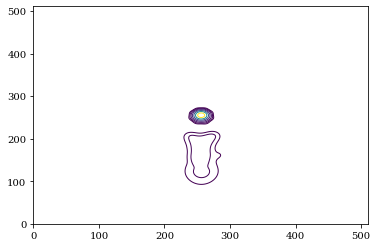

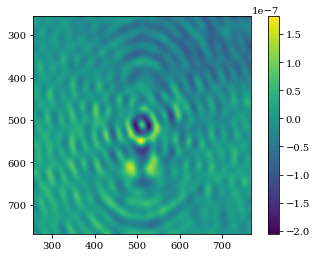

Producing clean visibilities from image with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


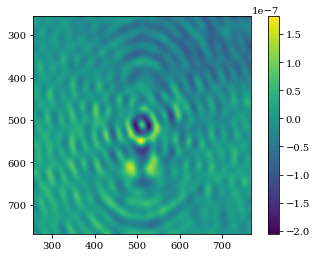

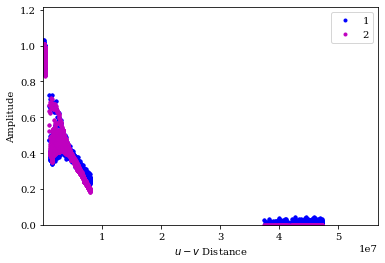

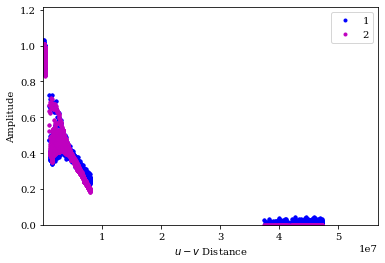

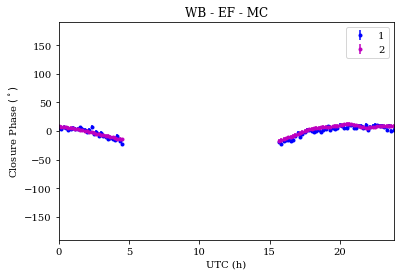

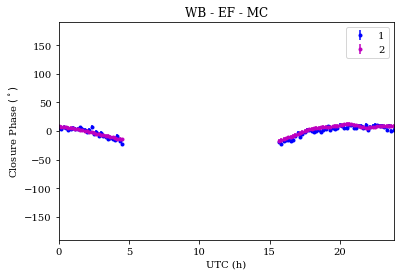

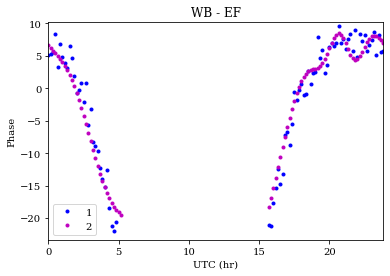

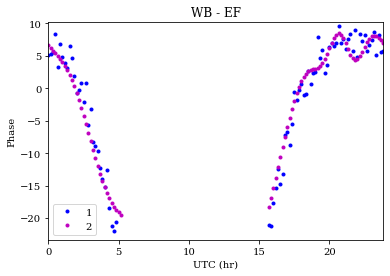

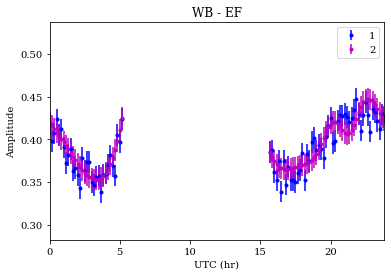

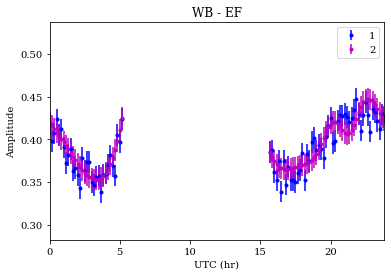

In [18]:
solver.display(psf=False)
solver.plot("dmap")
solver.plot("fit")

solver.plot("cphase", fields=['WB', 'EF', 'MC']) #closure phase
solver.plot("phase", fields=['WB', 'EF']) #phase
solver.plot("amp", fields=['WB', 'EF']) #amplitude

Now let us finalize the reconstrution. We have several opportunities for that. Further options are finalize_uniform (adding uniform residual) and finalize_diff (add diff to uniform residual).

2022-08-05 16:19:08,327 INFO CLEAN                :: Initialize solver ...
2022-08-05 16:19:08,328 INFO CLEAN                :: Initialize dirty beam and dirty map ...
2022-08-05 16:19:08,367 INFO CLEAN                :: Finalize initialization ...
2022-08-05 16:19:08,383 INFO CLEAN                :: Set restored map
2022-08-05 16:19:08,641 INFO CLEAN                :: Specify Plotting Bounds
2022-08-05 16:19:08,642 INFO CLEAN                :: [256 768 256 768]
2022-08-05 16:19:08,647 INFO CLEAN                :: Start running CLEAN with 1000 iterations
2022-08-05 16:19:08,772 INFO CountIterations      :: iteration = 1 / 1000
2022-08-05 16:19:08,899 INFO CountIterations      :: iteration = 2 / 1000
2022-08-05 16:19:09,021 INFO CountIterations      :: iteration = 3 / 1000
2022-08-05 16:19:09,143 INFO CountIterations      :: iteration = 4 / 1000
2022-08-05 16:19:09,264 INFO CountIterations      :: iteration = 5 / 1000
2022-08-05 16:19:09,398 INFO CountIterations      :: iteration = 6 / 

2114.1830012227106 cleaned at iteration  50
rms 3.1978475775558976e-08


2022-08-05 16:19:14,835 INFO CountIterations      :: iteration = 52 / 1000
2022-08-05 16:19:14,951 INFO CountIterations      :: iteration = 53 / 1000
2022-08-05 16:19:15,069 INFO CountIterations      :: iteration = 54 / 1000
2022-08-05 16:19:15,188 INFO CountIterations      :: iteration = 55 / 1000
2022-08-05 16:19:15,305 INFO CountIterations      :: iteration = 56 / 1000
2022-08-05 16:19:15,435 INFO CountIterations      :: iteration = 57 / 1000
2022-08-05 16:19:15,550 INFO CountIterations      :: iteration = 58 / 1000
2022-08-05 16:19:15,660 INFO CountIterations      :: iteration = 59 / 1000
2022-08-05 16:19:15,777 INFO CountIterations      :: iteration = 60 / 1000
2022-08-05 16:19:15,893 INFO CountIterations      :: iteration = 61 / 1000
2022-08-05 16:19:16,007 INFO CountIterations      :: iteration = 62 / 1000
2022-08-05 16:19:16,140 INFO CountIterations      :: iteration = 63 / 1000
2022-08-05 16:19:16,257 INFO CountIterations      :: iteration = 64 / 1000
2022-08-05 16:19:16,367 I

2114.1832483665485 cleaned at iteration  100
rms 3.028792967390693e-08


2022-08-05 16:19:20,743 INFO CountIterations      :: iteration = 102 / 1000
2022-08-05 16:19:20,858 INFO CountIterations      :: iteration = 103 / 1000
2022-08-05 16:19:20,989 INFO CountIterations      :: iteration = 104 / 1000
2022-08-05 16:19:21,106 INFO CountIterations      :: iteration = 105 / 1000
2022-08-05 16:19:21,225 INFO CountIterations      :: iteration = 106 / 1000
2022-08-05 16:19:21,335 INFO CountIterations      :: iteration = 107 / 1000
2022-08-05 16:19:21,451 INFO CountIterations      :: iteration = 108 / 1000
2022-08-05 16:19:21,565 INFO CountIterations      :: iteration = 109 / 1000
2022-08-05 16:19:21,695 INFO CountIterations      :: iteration = 110 / 1000
2022-08-05 16:19:21,813 INFO CountIterations      :: iteration = 111 / 1000
2022-08-05 16:19:21,931 INFO CountIterations      :: iteration = 112 / 1000
2022-08-05 16:19:22,041 INFO CountIterations      :: iteration = 113 / 1000
2022-08-05 16:19:22,157 INFO CountIterations      :: iteration = 114 / 1000
2022-08-05 1

2114.1834571028285 cleaned at iteration  150
rms 2.892073067904045e-08


2022-08-05 16:19:26,636 INFO CountIterations      :: iteration = 152 / 1000
2022-08-05 16:19:26,755 INFO CountIterations      :: iteration = 153 / 1000
2022-08-05 16:19:26,865 INFO CountIterations      :: iteration = 154 / 1000
2022-08-05 16:19:26,987 INFO CountIterations      :: iteration = 155 / 1000
2022-08-05 16:19:27,104 INFO CountIterations      :: iteration = 156 / 1000
2022-08-05 16:19:27,221 INFO CountIterations      :: iteration = 157 / 1000
2022-08-05 16:19:27,342 INFO CountIterations      :: iteration = 158 / 1000
2022-08-05 16:19:27,457 INFO CountIterations      :: iteration = 159 / 1000
2022-08-05 16:19:27,574 INFO CountIterations      :: iteration = 160 / 1000
2022-08-05 16:19:27,694 INFO CountIterations      :: iteration = 161 / 1000
2022-08-05 16:19:27,813 INFO CountIterations      :: iteration = 162 / 1000
2022-08-05 16:19:27,931 INFO CountIterations      :: iteration = 163 / 1000
2022-08-05 16:19:28,049 INFO CountIterations      :: iteration = 164 / 1000
2022-08-05 1

2114.1836424845574 cleaned at iteration  200
rms 2.7774798863332532e-08


2022-08-05 16:19:32,511 INFO CountIterations      :: iteration = 202 / 1000
2022-08-05 16:19:32,626 INFO CountIterations      :: iteration = 203 / 1000
2022-08-05 16:19:32,740 INFO CountIterations      :: iteration = 204 / 1000
2022-08-05 16:19:32,857 INFO CountIterations      :: iteration = 205 / 1000
2022-08-05 16:19:32,976 INFO CountIterations      :: iteration = 206 / 1000
2022-08-05 16:19:33,108 INFO CountIterations      :: iteration = 207 / 1000
2022-08-05 16:19:33,218 INFO CountIterations      :: iteration = 208 / 1000
2022-08-05 16:19:33,335 INFO CountIterations      :: iteration = 209 / 1000
2022-08-05 16:19:33,451 INFO CountIterations      :: iteration = 210 / 1000
2022-08-05 16:19:33,565 INFO CountIterations      :: iteration = 211 / 1000
2022-08-05 16:19:33,681 INFO CountIterations      :: iteration = 212 / 1000
2022-08-05 16:19:33,811 INFO CountIterations      :: iteration = 213 / 1000
2022-08-05 16:19:33,928 INFO CountIterations      :: iteration = 214 / 1000
2022-08-05 1

2114.1834740789254 cleaned at iteration  250
rms 2.648358948156657e-08


2022-08-05 16:19:38,250 INFO CountIterations      :: iteration = 252 / 1000
2022-08-05 16:19:38,368 INFO CountIterations      :: iteration = 253 / 1000
2022-08-05 16:19:38,485 INFO CountIterations      :: iteration = 254 / 1000
2022-08-05 16:19:38,596 INFO CountIterations      :: iteration = 255 / 1000
2022-08-05 16:19:38,710 INFO CountIterations      :: iteration = 256 / 1000
2022-08-05 16:19:38,839 INFO CountIterations      :: iteration = 257 / 1000
2022-08-05 16:19:38,933 INFO CountIterations      :: iteration = 258 / 1000
2022-08-05 16:19:39,049 INFO CountIterations      :: iteration = 259 / 1000
2022-08-05 16:19:39,167 INFO CountIterations      :: iteration = 260 / 1000
2022-08-05 16:19:39,283 INFO CountIterations      :: iteration = 261 / 1000
2022-08-05 16:19:39,393 INFO CountIterations      :: iteration = 262 / 1000
2022-08-05 16:19:39,512 INFO CountIterations      :: iteration = 263 / 1000
2022-08-05 16:19:39,643 INFO CountIterations      :: iteration = 264 / 1000
2022-08-05 1

2114.1830088240185 cleaned at iteration  300
rms 2.526157124963372e-08


2022-08-05 16:19:43,938 INFO CountIterations      :: iteration = 302 / 1000
2022-08-05 16:19:44,047 INFO CountIterations      :: iteration = 303 / 1000
2022-08-05 16:19:44,141 INFO CountIterations      :: iteration = 304 / 1000
2022-08-05 16:19:44,256 INFO CountIterations      :: iteration = 305 / 1000
2022-08-05 16:19:44,371 INFO CountIterations      :: iteration = 306 / 1000
2022-08-05 16:19:44,490 INFO CountIterations      :: iteration = 307 / 1000
2022-08-05 16:19:44,607 INFO CountIterations      :: iteration = 308 / 1000
2022-08-05 16:19:44,724 INFO CountIterations      :: iteration = 309 / 1000
2022-08-05 16:19:44,834 INFO CountIterations      :: iteration = 310 / 1000
2022-08-05 16:19:44,949 INFO CountIterations      :: iteration = 311 / 1000
2022-08-05 16:19:45,075 INFO CountIterations      :: iteration = 312 / 1000
2022-08-05 16:19:45,173 INFO CountIterations      :: iteration = 313 / 1000
2022-08-05 16:19:45,292 INFO CountIterations      :: iteration = 314 / 1000
2022-08-05 1

2114.1827258815083 cleaned at iteration  350
rms 2.4176806015987674e-08


2022-08-05 16:19:49,590 INFO CountIterations      :: iteration = 352 / 1000
2022-08-05 16:19:49,709 INFO CountIterations      :: iteration = 353 / 1000
2022-08-05 16:19:49,814 INFO CountIterations      :: iteration = 354 / 1000
2022-08-05 16:19:49,930 INFO CountIterations      :: iteration = 355 / 1000
2022-08-05 16:19:50,018 INFO CountIterations      :: iteration = 356 / 1000
2022-08-05 16:19:50,111 INFO CountIterations      :: iteration = 357 / 1000
2022-08-05 16:19:50,222 INFO CountIterations      :: iteration = 358 / 1000
2022-08-05 16:19:50,336 INFO CountIterations      :: iteration = 359 / 1000
2022-08-05 16:19:50,452 INFO CountIterations      :: iteration = 360 / 1000
2022-08-05 16:19:50,572 INFO CountIterations      :: iteration = 361 / 1000
2022-08-05 16:19:50,686 INFO CountIterations      :: iteration = 362 / 1000
2022-08-05 16:19:50,802 INFO CountIterations      :: iteration = 363 / 1000
2022-08-05 16:19:50,921 INFO CountIterations      :: iteration = 364 / 1000
2022-08-05 1

2114.1824600101113 cleaned at iteration  400
rms 2.308122284986066e-08


2022-08-05 16:19:55,207 INFO CountIterations      :: iteration = 402 / 1000
2022-08-05 16:19:55,324 INFO CountIterations      :: iteration = 403 / 1000
2022-08-05 16:19:55,441 INFO CountIterations      :: iteration = 404 / 1000
2022-08-05 16:19:55,541 INFO CountIterations      :: iteration = 405 / 1000
2022-08-05 16:19:55,671 INFO CountIterations      :: iteration = 406 / 1000
2022-08-05 16:19:55,788 INFO CountIterations      :: iteration = 407 / 1000
2022-08-05 16:19:55,907 INFO CountIterations      :: iteration = 408 / 1000
2022-08-05 16:19:56,041 INFO CountIterations      :: iteration = 409 / 1000
2022-08-05 16:19:56,156 INFO CountIterations      :: iteration = 410 / 1000
2022-08-05 16:19:56,274 INFO CountIterations      :: iteration = 411 / 1000
2022-08-05 16:19:56,398 INFO CountIterations      :: iteration = 412 / 1000
2022-08-05 16:19:56,492 INFO CountIterations      :: iteration = 413 / 1000
2022-08-05 16:19:56,586 INFO CountIterations      :: iteration = 414 / 1000
2022-08-05 1

2114.1820905424615 cleaned at iteration  450
rms 2.2089544291437205e-08


2022-08-05 16:20:00,823 INFO CountIterations      :: iteration = 452 / 1000
2022-08-05 16:20:00,938 INFO CountIterations      :: iteration = 453 / 1000
2022-08-05 16:20:01,041 INFO CountIterations      :: iteration = 454 / 1000
2022-08-05 16:20:01,154 INFO CountIterations      :: iteration = 455 / 1000
2022-08-05 16:20:01,260 INFO CountIterations      :: iteration = 456 / 1000
2022-08-05 16:20:01,359 INFO CountIterations      :: iteration = 457 / 1000
2022-08-05 16:20:01,469 INFO CountIterations      :: iteration = 458 / 1000
2022-08-05 16:20:01,584 INFO CountIterations      :: iteration = 459 / 1000
2022-08-05 16:20:01,702 INFO CountIterations      :: iteration = 460 / 1000
2022-08-05 16:20:01,816 INFO CountIterations      :: iteration = 461 / 1000
2022-08-05 16:20:01,935 INFO CountIterations      :: iteration = 462 / 1000
2022-08-05 16:20:02,061 INFO CountIterations      :: iteration = 463 / 1000
2022-08-05 16:20:02,178 INFO CountIterations      :: iteration = 464 / 1000
2022-08-05 1

2114.181854123258 cleaned at iteration  500
rms 2.127710508485829e-08


2022-08-05 16:20:06,446 INFO CountIterations      :: iteration = 502 / 1000
2022-08-05 16:20:06,562 INFO CountIterations      :: iteration = 503 / 1000
2022-08-05 16:20:06,662 INFO CountIterations      :: iteration = 504 / 1000
2022-08-05 16:20:06,771 INFO CountIterations      :: iteration = 505 / 1000
2022-08-05 16:20:06,882 INFO CountIterations      :: iteration = 506 / 1000
2022-08-05 16:20:06,982 INFO CountIterations      :: iteration = 507 / 1000
2022-08-05 16:20:07,101 INFO CountIterations      :: iteration = 508 / 1000
2022-08-05 16:20:07,218 INFO CountIterations      :: iteration = 509 / 1000
2022-08-05 16:20:07,335 INFO CountIterations      :: iteration = 510 / 1000
2022-08-05 16:20:07,445 INFO CountIterations      :: iteration = 511 / 1000
2022-08-05 16:20:07,556 INFO CountIterations      :: iteration = 512 / 1000
2022-08-05 16:20:07,661 INFO CountIterations      :: iteration = 513 / 1000
2022-08-05 16:20:07,765 INFO CountIterations      :: iteration = 514 / 1000
2022-08-05 1

2114.1814103039696 cleaned at iteration  550
rms 2.044301616341817e-08


2022-08-05 16:20:11,987 INFO CountIterations      :: iteration = 552 / 1000
2022-08-05 16:20:12,104 INFO CountIterations      :: iteration = 553 / 1000
2022-08-05 16:20:12,205 INFO CountIterations      :: iteration = 554 / 1000
2022-08-05 16:20:12,335 INFO CountIterations      :: iteration = 555 / 1000
2022-08-05 16:20:12,444 INFO CountIterations      :: iteration = 556 / 1000
2022-08-05 16:20:12,544 INFO CountIterations      :: iteration = 557 / 1000
2022-08-05 16:20:12,637 INFO CountIterations      :: iteration = 558 / 1000
2022-08-05 16:20:12,755 INFO CountIterations      :: iteration = 559 / 1000
2022-08-05 16:20:12,872 INFO CountIterations      :: iteration = 560 / 1000
2022-08-05 16:20:12,998 INFO CountIterations      :: iteration = 561 / 1000
2022-08-05 16:20:13,115 INFO CountIterations      :: iteration = 562 / 1000
2022-08-05 16:20:13,224 INFO CountIterations      :: iteration = 563 / 1000
2022-08-05 16:20:13,340 INFO CountIterations      :: iteration = 564 / 1000
2022-08-05 1

2114.1809961828653 cleaned at iteration  600
rms 1.9677776758309013e-08


2022-08-05 16:20:17,540 INFO CountIterations      :: iteration = 602 / 1000
2022-08-05 16:20:17,658 INFO CountIterations      :: iteration = 603 / 1000
2022-08-05 16:20:17,744 INFO CountIterations      :: iteration = 604 / 1000
2022-08-05 16:20:17,860 INFO CountIterations      :: iteration = 605 / 1000
2022-08-05 16:20:17,974 INFO CountIterations      :: iteration = 606 / 1000
2022-08-05 16:20:18,083 INFO CountIterations      :: iteration = 607 / 1000
2022-08-05 16:20:18,213 INFO CountIterations      :: iteration = 608 / 1000
2022-08-05 16:20:18,303 INFO CountIterations      :: iteration = 609 / 1000
2022-08-05 16:20:18,420 INFO CountIterations      :: iteration = 610 / 1000
2022-08-05 16:20:18,530 INFO CountIterations      :: iteration = 611 / 1000
2022-08-05 16:20:18,640 INFO CountIterations      :: iteration = 612 / 1000
2022-08-05 16:20:18,755 INFO CountIterations      :: iteration = 613 / 1000
2022-08-05 16:20:18,856 INFO CountIterations      :: iteration = 614 / 1000
2022-08-05 1

2114.1807034785306 cleaned at iteration  650
rms 1.8987033887880576e-08


2022-08-05 16:20:23,093 INFO CountIterations      :: iteration = 652 / 1000
2022-08-05 16:20:23,209 INFO CountIterations      :: iteration = 653 / 1000
2022-08-05 16:20:23,325 INFO CountIterations      :: iteration = 654 / 1000
2022-08-05 16:20:23,439 INFO CountIterations      :: iteration = 655 / 1000
2022-08-05 16:20:23,548 INFO CountIterations      :: iteration = 656 / 1000
2022-08-05 16:20:23,664 INFO CountIterations      :: iteration = 657 / 1000
2022-08-05 16:20:23,764 INFO CountIterations      :: iteration = 658 / 1000
2022-08-05 16:20:23,885 INFO CountIterations      :: iteration = 659 / 1000
2022-08-05 16:20:23,991 INFO CountIterations      :: iteration = 660 / 1000
2022-08-05 16:20:24,091 INFO CountIterations      :: iteration = 661 / 1000
2022-08-05 16:20:24,190 INFO CountIterations      :: iteration = 662 / 1000
2022-08-05 16:20:24,300 INFO CountIterations      :: iteration = 663 / 1000
2022-08-05 16:20:24,417 INFO CountIterations      :: iteration = 664 / 1000
2022-08-05 1

2114.1805185174862 cleaned at iteration  700
rms 1.840342434169627e-08


2022-08-05 16:20:28,647 INFO CountIterations      :: iteration = 702 / 1000
2022-08-05 16:20:28,761 INFO CountIterations      :: iteration = 703 / 1000
2022-08-05 16:20:28,866 INFO CountIterations      :: iteration = 704 / 1000
2022-08-05 16:20:28,984 INFO CountIterations      :: iteration = 705 / 1000
2022-08-05 16:20:29,092 INFO CountIterations      :: iteration = 706 / 1000
2022-08-05 16:20:29,188 INFO CountIterations      :: iteration = 707 / 1000
2022-08-05 16:20:29,288 INFO CountIterations      :: iteration = 708 / 1000
2022-08-05 16:20:29,380 INFO CountIterations      :: iteration = 709 / 1000
2022-08-05 16:20:29,505 INFO CountIterations      :: iteration = 710 / 1000
2022-08-05 16:20:29,624 INFO CountIterations      :: iteration = 711 / 1000
2022-08-05 16:20:29,735 INFO CountIterations      :: iteration = 712 / 1000
2022-08-05 16:20:29,852 INFO CountIterations      :: iteration = 713 / 1000
2022-08-05 16:20:29,971 INFO CountIterations      :: iteration = 714 / 1000
2022-08-05 1

2114.1802548157866 cleaned at iteration  750
rms 1.772454723585385e-08


2022-08-05 16:20:34,073 INFO CountIterations      :: iteration = 752 / 1000
2022-08-05 16:20:34,183 INFO CountIterations      :: iteration = 753 / 1000
2022-08-05 16:20:34,283 INFO CountIterations      :: iteration = 754 / 1000
2022-08-05 16:20:34,389 INFO CountIterations      :: iteration = 755 / 1000
2022-08-05 16:20:34,506 INFO CountIterations      :: iteration = 756 / 1000
2022-08-05 16:20:34,621 INFO CountIterations      :: iteration = 757 / 1000
2022-08-05 16:20:34,716 INFO CountIterations      :: iteration = 758 / 1000
2022-08-05 16:20:34,824 INFO CountIterations      :: iteration = 759 / 1000
2022-08-05 16:20:34,944 INFO CountIterations      :: iteration = 760 / 1000
2022-08-05 16:20:35,044 INFO CountIterations      :: iteration = 761 / 1000
2022-08-05 16:20:35,147 INFO CountIterations      :: iteration = 762 / 1000
2022-08-05 16:20:35,260 INFO CountIterations      :: iteration = 763 / 1000
2022-08-05 16:20:35,375 INFO CountIterations      :: iteration = 764 / 1000
2022-08-05 1

2114.180172161724 cleaned at iteration  800
rms 1.7121812693377785e-08


2022-08-05 16:20:39,538 INFO CountIterations      :: iteration = 802 / 1000
2022-08-05 16:20:39,645 INFO CountIterations      :: iteration = 803 / 1000
2022-08-05 16:20:39,764 INFO CountIterations      :: iteration = 804 / 1000
2022-08-05 16:20:39,881 INFO CountIterations      :: iteration = 805 / 1000
2022-08-05 16:20:39,999 INFO CountIterations      :: iteration = 806 / 1000
2022-08-05 16:20:40,122 INFO CountIterations      :: iteration = 807 / 1000
2022-08-05 16:20:40,209 INFO CountIterations      :: iteration = 808 / 1000
2022-08-05 16:20:40,318 INFO CountIterations      :: iteration = 809 / 1000
2022-08-05 16:20:40,417 INFO CountIterations      :: iteration = 810 / 1000
2022-08-05 16:20:40,535 INFO CountIterations      :: iteration = 811 / 1000
2022-08-05 16:20:40,636 INFO CountIterations      :: iteration = 812 / 1000
2022-08-05 16:20:40,727 INFO CountIterations      :: iteration = 813 / 1000
2022-08-05 16:20:40,849 INFO CountIterations      :: iteration = 814 / 1000
2022-08-05 1

2114.180088381702 cleaned at iteration  850
rms 1.6564596551167945e-08


2022-08-05 16:20:45,008 INFO CountIterations      :: iteration = 852 / 1000
2022-08-05 16:20:45,122 INFO CountIterations      :: iteration = 853 / 1000
2022-08-05 16:20:45,237 INFO CountIterations      :: iteration = 854 / 1000
2022-08-05 16:20:45,335 INFO CountIterations      :: iteration = 855 / 1000
2022-08-05 16:20:45,433 INFO CountIterations      :: iteration = 856 / 1000
2022-08-05 16:20:45,551 INFO CountIterations      :: iteration = 857 / 1000
2022-08-05 16:20:45,674 INFO CountIterations      :: iteration = 858 / 1000
2022-08-05 16:20:45,764 INFO CountIterations      :: iteration = 859 / 1000
2022-08-05 16:20:45,881 INFO CountIterations      :: iteration = 860 / 1000
2022-08-05 16:20:45,997 INFO CountIterations      :: iteration = 861 / 1000
2022-08-05 16:20:46,105 INFO CountIterations      :: iteration = 862 / 1000
2022-08-05 16:20:46,215 INFO CountIterations      :: iteration = 863 / 1000
2022-08-05 16:20:46,335 INFO CountIterations      :: iteration = 864 / 1000
2022-08-05 1

2114.179931952801 cleaned at iteration  900
rms 1.603568598192314e-08


2022-08-05 16:20:50,481 INFO CountIterations      :: iteration = 902 / 1000
2022-08-05 16:20:50,590 INFO CountIterations      :: iteration = 903 / 1000
2022-08-05 16:20:50,695 INFO CountIterations      :: iteration = 904 / 1000
2022-08-05 16:20:50,805 INFO CountIterations      :: iteration = 905 / 1000
2022-08-05 16:20:50,902 INFO CountIterations      :: iteration = 906 / 1000
2022-08-05 16:20:51,007 INFO CountIterations      :: iteration = 907 / 1000
2022-08-05 16:20:51,106 INFO CountIterations      :: iteration = 908 / 1000
2022-08-05 16:20:51,217 INFO CountIterations      :: iteration = 909 / 1000
2022-08-05 16:20:51,334 INFO CountIterations      :: iteration = 910 / 1000
2022-08-05 16:20:51,457 INFO CountIterations      :: iteration = 911 / 1000
2022-08-05 16:20:51,559 INFO CountIterations      :: iteration = 912 / 1000
2022-08-05 16:20:51,675 INFO CountIterations      :: iteration = 913 / 1000
2022-08-05 16:20:51,785 INFO CountIterations      :: iteration = 914 / 1000
2022-08-05 1

2114.1798576100973 cleaned at iteration  950
rms 1.560784924627037e-08


2022-08-05 16:20:56,033 INFO CountIterations      :: iteration = 953 / 1000
2022-08-05 16:20:56,141 INFO CountIterations      :: iteration = 954 / 1000
2022-08-05 16:20:56,227 INFO CountIterations      :: iteration = 955 / 1000
2022-08-05 16:20:56,326 INFO CountIterations      :: iteration = 956 / 1000
2022-08-05 16:20:56,437 INFO CountIterations      :: iteration = 957 / 1000
2022-08-05 16:20:56,540 INFO CountIterations      :: iteration = 958 / 1000
2022-08-05 16:20:56,649 INFO CountIterations      :: iteration = 959 / 1000
2022-08-05 16:20:56,782 INFO CountIterations      :: iteration = 960 / 1000
2022-08-05 16:20:56,887 INFO CountIterations      :: iteration = 961 / 1000
2022-08-05 16:20:56,988 INFO CountIterations      :: iteration = 962 / 1000
2022-08-05 16:20:57,081 INFO CountIterations      :: iteration = 963 / 1000
2022-08-05 16:20:57,178 INFO CountIterations      :: iteration = 964 / 1000
2022-08-05 16:20:57,286 INFO CountIterations      :: iteration = 965 / 1000
2022-08-05 1

2114.1797846280397 cleaned at iteration  1000
rms 1.5140588831381635e-08


2022-08-05 16:21:01,293 INFO CLEAN                :: Solver finished
2022-08-05 16:21:01,310 INFO CLEAN                :: std: 1.1620783741466506e-09
2022-08-05 16:21:01,311 INFO CLEAN                :: at iteration: 1000
2022-08-05 16:21:01,319 INFO CLEAN                :: total flux 1.0191444323669354
2022-08-05 16:21:01,690 INFO CLEAN                :: Merge component list


clipping values less than 0 in display


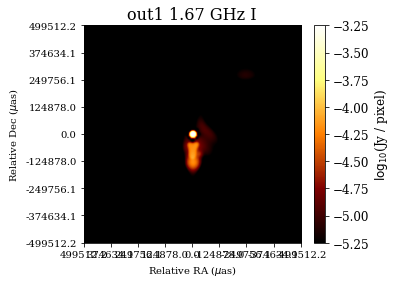

clipping values less than 0 in display


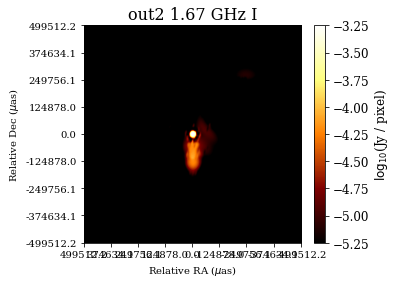

clipping values less than 0 in display


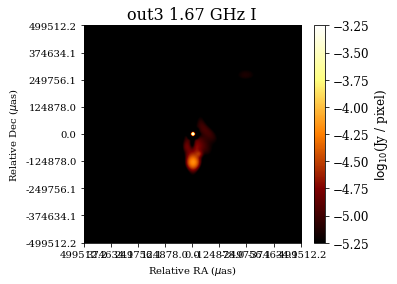

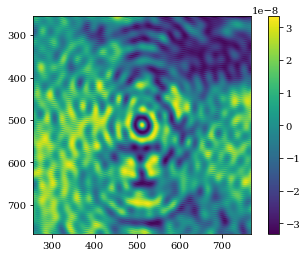

Producing clean visibilities from image with fast FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


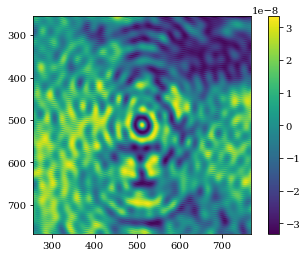

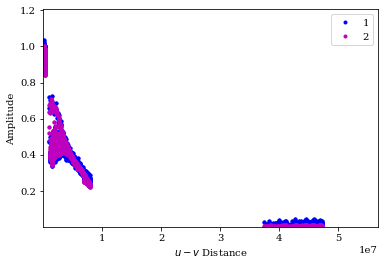

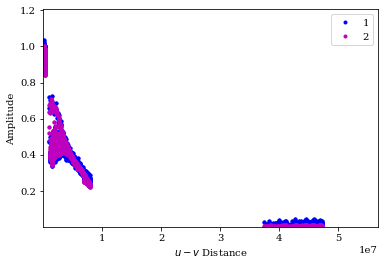

In [20]:
out1 = solver.finalize() #add final residual only
model, out2 = solver.finalize_clean(psf_from_prior=True) #clean last residual with a short Hogbom-CLEAN run
out3 = solver.wrapper.formatoutput(solver.add_missing_scales(factor=0.1)) #copy the signal from neighbouring scales into gaps, should be used only with relative caution as non-measured signal introduced into the imaging procedure

out1.source = 'out1'
out2.source = 'out2'
out3.source = 'out3'

out1.display(scale='log', cbar_lims=[-5.25, -3.25])
out2.display(scale='log', cbar_lims=[-5.25, -3.25])
out3.display(scale='log', cbar_lims=[-5.25, -3.25])

solver.solver_hogbom.plot("dmap")
solver.solver_hogbom.plot("fit")

We present some advanced imaging options now in the remainder that were not used in the upper example. First, we have the opportunity to select only specific scales for the imaging procedure, or we select only one scale that is most sensitive to the data point with the currently wost fit. As default all scales are used. Note that the relative eighting between the scales is handled internally and has been proven to be optimal, such that the option of single scale selections should be only used when you are really sure about what you are doing.

In [21]:
solver.select_scales([4,5]) #select only scales 4 and 5 for imaging

#solver.prepare_scale_selection() #prepares all arrays that are needed for finding the most-sensitive scale
#solver.select_best_scale() #finds the data point with the largest difference between recovered solution and observation and selects the scale that is most sensitive to this data point

#solver.flag_longest() #if this data point has a problem, just flag it out of the selection and select the next one
#solver.flag_smoothing_scale() #similarly one could flag the complete fulx-transporting smoothing scale from the selection of the best scale
#solver.select_best_scale() #select best scale again

solver.select_all_scales() #select all scales (default)

2022-08-05 16:21:31,422 INFO CLEAN                :: Update weights
2022-08-05 16:21:31,425 INFO CLEAN                :: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
2022-08-05 16:21:31,426 INFO CLEAN                :: Update weights
2022-08-05 16:21:31,427 INFO CLEAN                :: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


To deal with calibration issues one can use the commands startcal and selfcal (not done now to save memory).

In [22]:
#solver.startcal(method='phase') #phase calibrate to startmodel of wrapper (was psfprior in our case)
#solver.selfcal(method='phase') #phase calibration to current model (solver.reco)

Furthermore, MrBeam provides some modelfitting options to model the remaining flux (does not do anything here since the total flux is already fitted correctly).

2022-08-05 16:21:38,569 INFO CLEAN                :: Update weights
2022-08-05 16:21:38,570 INFO CLEAN                :: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
2022-08-05 16:21:39,108 INFO CLEAN                :: Update weights
2022-08-05 16:21:39,110 INFO CLEAN                :: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


clipping values less than 0 in display


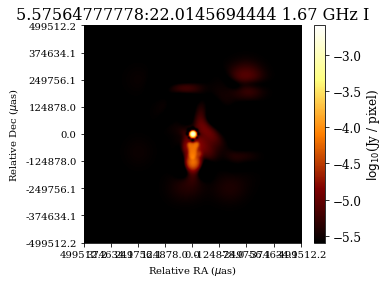

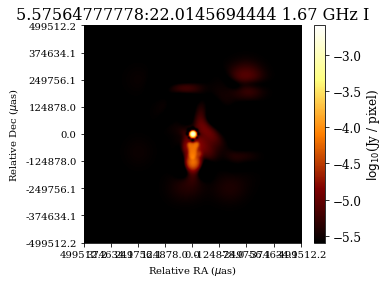

In [23]:
solver.modelfit(10**6)
out = wrapper.formatoutput(solver.reco)
out.display(scale='log')

Finally the dirty map, dirty beam, clean map and window could be all stored together by the command solver.save(path)